
# Projet 5 - Segmentation des Clients d'un Site E-Commerce
## Partie 1 de 3

# 1. Introduction à la Problématique 

## 1.1 Le Contexte

Olist, une solution de vente sur les marketplaces en ligne, souhaite donner à ses équipes d'e-commerce une segmentation des clients qu’elles pourront utiliser au quotidien pour leurs campagnes de communication.

Lien de leur website: https://olist.com/pt-br/

## 1.2 Les Objectives / La Missions

* **comprendre les différents types d’utilisateurs** grâce à leur comportement et à leurs données personnelles
* fournir à l’équipe marketing **une description actionable de la segmentation** et de sa logique sous-jacente pour une utilisation optimale
* **proposer un contrat de maintenance** basée sur une analyse de la stabilité des segments au cours du temps

## 1.3 Les Spécifications

* La segmentation proposée doit être **exploitable et facile d’utilisation pour l’équipe marketing**.
* Vous évaluerez la fréquence à laquelle la segmentation doit être mise à jour, afin de pouvoir effectuer un devis de **contrat de maintenance**.
* Le code fourni doit respecter la convention PEP8, pour être utilisable par Olist.

## 1.4 Les Données

Olist fournit une base de données anonymisée comportant des informations sur l’historique des commandes, les produits achetés, les commentaires de satisfaction, et la localisation des clients depuis janvier 2017.

Lien : https://www.kaggle.com/olistbr/brazilian-ecommerce

### 1.4.1 Structure du Dataset

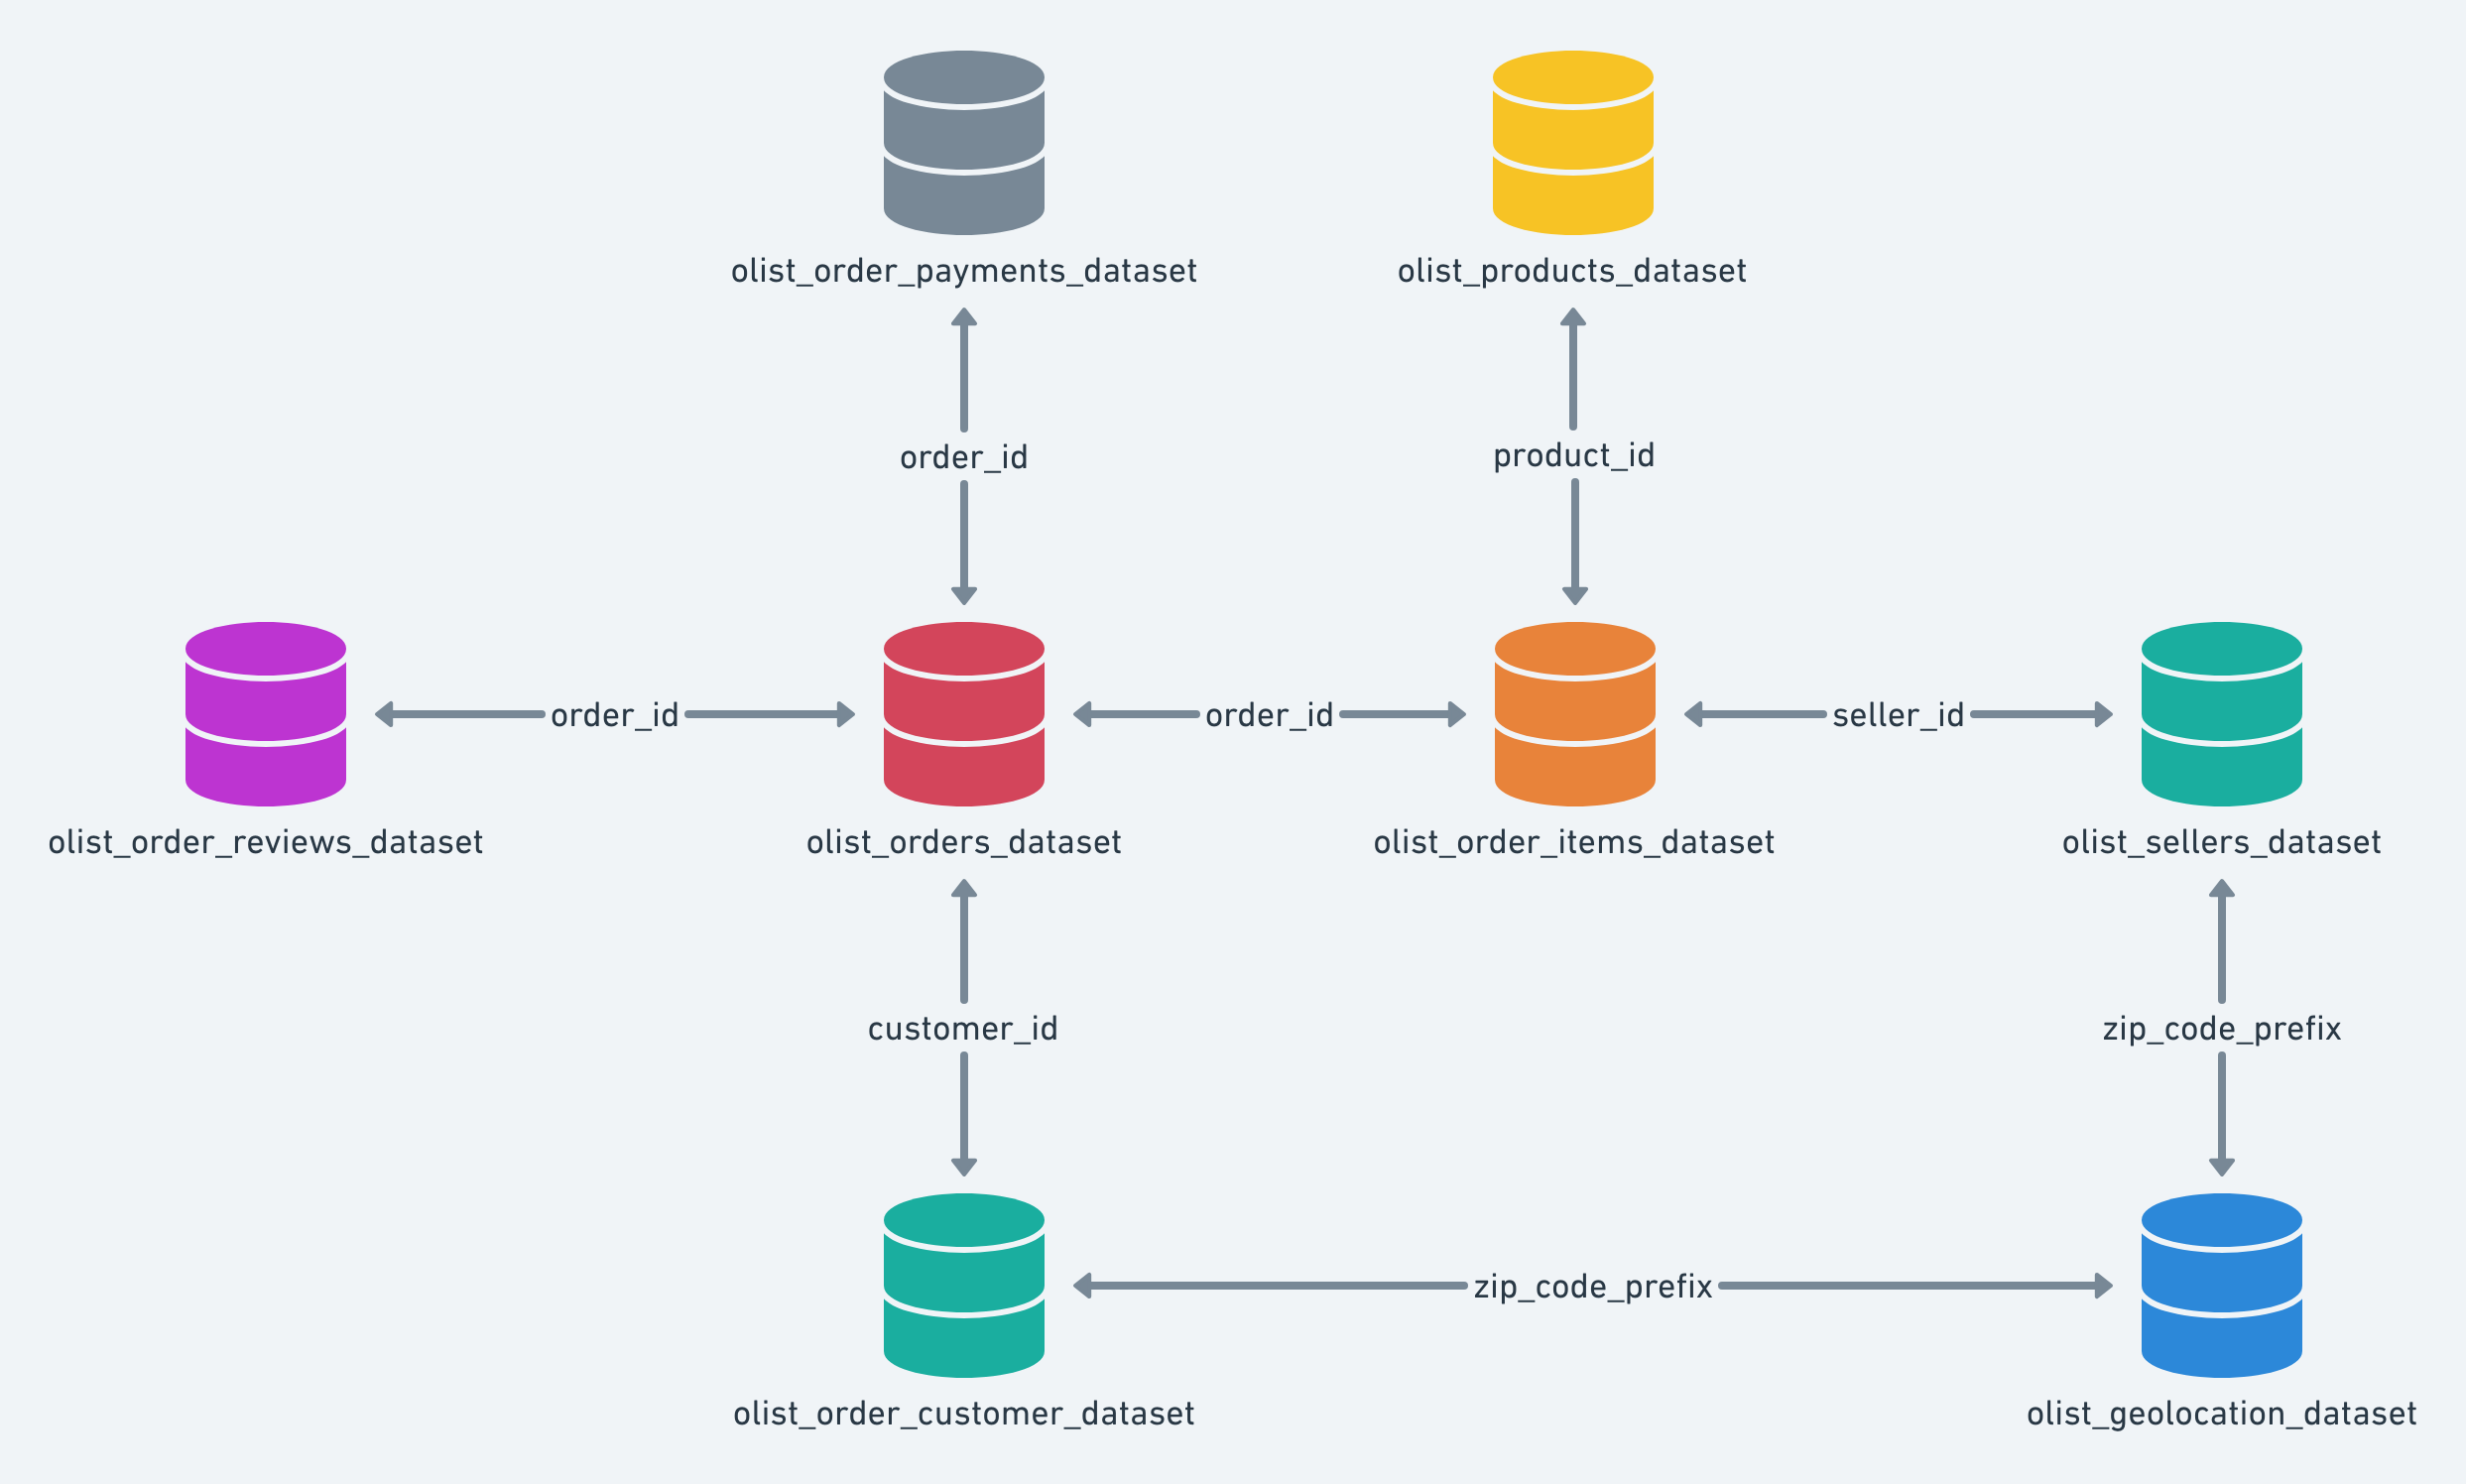

### 1.4.2 Notes sur les Données

Une fois que le client a reçu le produit ou que la date de livraison estimée est due, le client reçoit une enquête de satisfaction par e-mail où il peut donner une note pour l'expérience d'achat et écrire quelques commentaires.

1. Une commande peut contenir plusieurs articles.
2. Chaque article peut être rempli par un vendeur distinct.
3. Tous les textes identifiant les magasins et les partenaires ont été remplacés par les noms des grandes maisons de Game of Thrones.

### 1.4.3 Resources

**EDA**

https://www.kaggle.com/fayhosseini/brazilian-e-commerce-eda-for-beginners

https://www.kaggle.com/kabure/simple-eda-sales-and-customer-patterns

https://www.kaggle.com/ashikm96/e-commerce-analysis-olist-data

https://www.kaggle.com/thiagopanini/e-commerce-sentiment-analysis-eda-viz-nlp

https://www.kaggle.com/jsaguiar/e-commerce-exploratory-analysis


**Analysis Geospatial**

https://www.kaggle.com/andresionek/geospatial-analysis-of-brazilian-e-commerce


**Analysis Poussées**


https://www.kaggle.com/andresionek/predicting-customer-satisfaction


# 2. Les Imports et Fonctions

## 2.1 Les Bibliothèques et Styles

In [1]:
#imports: regular expresssions, operating system, math operations
#import re,os,math
import re, os, random, datetime
from math import sin, cos, sqrt, atan2, radians, degrees
from cmath import rect, phase
from ast import literal_eval

#data modules
import numpy as np
import pandas as pd
import scipy as sp

#graphic modules
import matplotlib.pyplot as plt
import matplotlib.dates as dates
import seaborn as sns

In [2]:
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA

In [3]:
sns.set() #sets the theme of seaborn
#creates static png images of the plots within the notebook (other option: 'notebook' for interactive plots)
%matplotlib inline 

In [4]:
%%html
<style>
    table {
        display: inline-block
    }
</style>

## 2.2 Les Fonctions

In [5]:
def mean_angle(deg):
    '''Determiation of the mean angle using radial coordinates - the radius r=1. '''
    
    return degrees(phase(sum(rect(1, radians(d)) for d in deg)/len(deg)))

In [6]:
def mean_time(times):
    '''Projection of time inputs onto a circle in order to determine the average time of day.'''
    
    #t = (time.split(':') for time in times)
    t = [(time.hour, time.minute, time.second) for time in times]
    seconds = ((float(s) + int(m) * 60 + int(h) * 3600) 
               for h, m, s in t)
    day = 24 * 60 * 60
    to_angles = [s * 360. / day for s in seconds]
    mean_as_angle = mean_angle(to_angles)
    mean_seconds = mean_as_angle * day / 360.
    if mean_seconds < 0:
        mean_seconds += day
    h, m = divmod(mean_seconds, 3600)
    m, s = divmod(m, 60)
    
    return datetime.time(int(h), int(m), int(s))

In [7]:
def get_avg_timestamp(x):
    '''Calculation of the average time for a DataFrame with multiple columns as possible inputs.'''
    times = []
    for c in x.columns:
        tmp = x[c].dropna()
        if len(tmp):
            times+=list(tmp.dt.time.values)
    if len(times):
        avg = mean_time(times)
    else: avg = np.nan
    return avg

In [8]:
def get_distance(point1, point2):
    '''Calculation of the distance (in meters) between two points, 
    whose location is given by the gps-coordinates: latitude and longitude'''
    
    R = 6378.137 #Radius of Earth in km
    lat1 = radians(point1[0])  #insert value
    lon1 = radians(point1[1])
    lat2 = radians(point2[0])
    lon2 = radians(point2[1])

    dlon = lon2 - lon1
    dlat = lat2- lat1

    a = sin(dlat / 2)**2 + cos(lat1) * cos(lat2) * sin(dlon / 2)**2
    c = 2 * atan2(sqrt(a), sqrt(1-a))
    distance = R * c
    
    return distance*1000 # in meters

In [9]:
def plot_box_violin(data, xlabel, func, figsize=(16,4)):
    '''Pot a box and violin plot on top of each other.'''
    data = data.dropna()
    
    cols = int(func != None) + 1
    
    fig, axes = plt.subplots(1,cols, figsize=figsize, sharey=True)
    ax = axes[0] if (cols > 1) else axes
    ax.boxplot(data, showmeans = True, showfliers = True, vert=False)
    ax.violinplot(data, showextrema = False, vert=False)
    ax.set_xlabel(xlabel)
    
    if func != None:
        ax = axes[1]
        ax.boxplot(data.apply(func), showmeans = True, showfliers = True, vert=False)
        ax.violinplot(data.apply(func), showextrema = False, vert=False)
        ax.set_xlabel(xlabel+'_rescaled')

    ax = axes[0] if (cols > 1) else axes
    ax.set_yticks(ticks = [i+1 for i in range(len(data.columns))])
    ax.set_yticklabels(labels=data.columns.values, rotation='vertical', va='center')

    #plt.yticks(ticks = [i+1 for i in range(len(data.columns))])
    plt.show()

In [10]:
def display_scree_plot(pca, name='',savefigure = False):
    '''Display a scree plot for the pca'''

    scree = pca.explained_variance_ratio_*100
    plt.bar(np.arange(len(scree))+1, scree)
    plt.plot(np.arange(len(scree))+1, scree.cumsum(),c="red",marker='o')
    plt.xlabel("Rang de l'axe d'inertie")
    plt.ylabel("Pourcentage d'inertie")
    plt.title("Eboulis des valeurs propres")
    #plt.title("Scree plot")
    if savefigure :
        plt.savefig(os.getcwd() + '\\Figures\\' + name +'_ScreePlot', dpi = 200)
    plt.show(block=False)

In [11]:
def display_circles(pcs, n_comp, pca, axis_ranks, labels=None, label_rotation=0, lims=None):
    """Display correlation circles, one for each factorial plane"""

    # For each factorial plane
    for d1, d2 in axis_ranks: 
        if d2 < n_comp:

            # Initialise the matplotlib figure
            fig, ax = plt.subplots(figsize=(10,10))

            # Determine the limits of the chart
            if lims is not None :
                xmin, xmax, ymin, ymax = lims
            elif pcs.shape[1] < 30 :
                xmin, xmax, ymin, ymax = -1, 1, -1, 1
            else :
                xmin, xmax, ymin, ymax = min(pcs[d1,:]), max(pcs[d1,:]), min(pcs[d2,:]), max(pcs[d2,:])

            # Add arrows
            # If there are more than 30 arrows, we do not display the triangle at the end
            if pcs.shape[1] < 30 :
                plt.quiver(np.zeros(pcs.shape[1]), np.zeros(pcs.shape[1]),
                   pcs[d1,:], pcs[d2,:], 
                   angles='xy', scale_units='xy', scale=1, color="grey")
                # (see the doc : https://matplotlib.org/api/_as_gen/matplotlib.pyplot.quiver.html)
            else:
                lines = [[[0,0],[x,y]] for x,y in pcs[[d1,d2]].T]
                ax.add_collection(LineCollection(lines, axes=ax, alpha=.1, color='black'))
            
            # Display variable names
            if labels is not None:  
                for i,(x, y) in enumerate(pcs[[d1,d2]].T):
                    if x >= xmin and x <= xmax and y >= ymin and y <= ymax :
                        plt.text(x, y, labels[i], fontsize='14', ha='center', va='center', 
                                 rotation=label_rotation, color="blue", alpha=0.5)
            
            # Display circle
            circle = plt.Circle((0,0), 1, facecolor='none', edgecolor='b')
            plt.gca().add_artist(circle)

            # Define the limits of the chart
            #plt.xlim(xmin, xmax)
            #plt.ylim(ymin, ymax)
        
            # Display grid lines
            plt.plot([-1, 1], [0, 0], color='grey', ls='--')
            plt.plot([0, 0], [-1, 1], color='grey', ls='--')

            # Label the axes, with the percentage of variance explained
            plt.xlabel('PC{} ({}%)'.format(d1+1, round(100*pca.explained_variance_ratio_[d1],1)))
            plt.ylabel('PC{} ({}%)'.format(d2+1, round(100*pca.explained_variance_ratio_[d2],1)))

            plt.title("Correlation Circle (PC{} and PC{})".format(d1+1, d2+1))
            plt.show(block=False)

## 2.3 Les Données

### 2.3.1 Téléchargement des Données

In [12]:
PATH_TO_DATA = os.getcwd() + '\\data\\'
datasets = {}
datanames = ['customers', 'geolocation', 'order_items', 'order_payments', 'order_reviews','orders',
             'products', 'sellers']
for dataname in datanames:
    datasets[dataname] = pd.read_csv(PATH_TO_DATA + '_'.join(['olist', dataname, 'dataset']) + '.csv')
datasets['category_translation'] = pd.read_csv(PATH_TO_DATA + 'product_category_name_translation.csv')

### 2.3.2 Un Premier Regarde sur les Données

#### Vérification du Téléchargement

On vérifie que le téléchargements des données c'est bien passé.

In [13]:
for k, data in datasets.items():
    print(k)
    display(data.head())

customers


,customer_id,customer_unique_id,customer_zip_code_prefix,customer_city,customer_state
0,06b8999e2fba1a1fbc88172c00ba8bc7,861eff4711a542e4b93843c6dd7febb0,14409,franca,SP
1,18955e83d337fd6b2def6b18a428ac77,290c77bc529b7ac935b93aa66c333dc3,9790,sao bernardo do campo,SP
2,4e7b3e00288586ebd08712fdd0374a03,060e732b5b29e8181a18229c7b0b2b5e,1151,sao paulo,SP
3,b2b6027bc5c5109e529d4dc6358b12c3,259dac757896d24d7702b9acbbff3f3c,8775,mogi das cruzes,SP
4,4f2d8ab171c80ec8364f7c12e35b23ad,345ecd01c38d18a9036ed96c73b8d066,13056,campinas,SP


geolocation


,geolocation_zip_code_prefix,geolocation_lat,geolocation_lng,geolocation_city,geolocation_state
0,1037,-23.545621,-46.639292,sao paulo,SP
1,1046,-23.546081,-46.644820,sao paulo,SP
2,1046,-23.546129,-46.642951,sao paulo,SP
3,1041,-23.544392,-46.639499,sao paulo,SP
4,1035,-23.541578,-46.641607,sao paulo,SP


order_items


,order_id,order_item_id,product_id,seller_id,shipping_limit_date,price,freight_value
0,00010242fe8c5a6d1ba2dd792cb16214,1,4244733e06e7ecb4970a6e2683c13e61,48436dade18ac8b2bce089ec2a041202,2017-09-19 09:45:35,58.90,13.29
1,00018f77f2f0320c557190d7a144bdd3,1,e5f2d52b802189ee658865ca93d83a8f,dd7ddc04e1b6c2c614352b383efe2d36,2017-05-03 11:05:13,239.90,19.93
2,000229ec398224ef6ca0657da4fc703e,1,c777355d18b72b67abbeef9df44fd0fd,5b51032eddd242adc84c38acab88f23d,2018-01-18 14:48:30,199.00,17.87
3,00024acbcdf0a6daa1e931b038114c75,1,7634da152a4610f1595efa32f14722fc,9d7a1d34a5052409006425275ba1c2b4,2018-08-15 10:10:18,12.99,12.79
4,00042b26cf59d7ce69dfabb4e55b4fd9,1,ac6c3623068f30de03045865e4e10089,df560393f3a51e74553ab94004ba5c87,2017-02-13 13:57:51,199.90,18.14


order_payments


,order_id,payment_sequential,payment_type,payment_installments,payment_value
0,b81ef226f3fe1789b1e8b2acac839d17,1,credit_card,8,99.33
1,a9810da82917af2d9aefd1278f1dcfa0,1,credit_card,1,24.39
2,25e8ea4e93396b6fa0d3dd708e76c1bd,1,credit_card,1,65.71
3,ba78997921bbcdc1373bb41e913ab953,1,credit_card,8,107.78
4,42fdf880ba16b47b59251dd489d4441a,1,credit_card,2,128.45


order_reviews


,review_id,order_id,review_score,review_comment_title,review_comment_message,review_creation_date,review_answer_timestamp
0,7bc2406110b926393aa56f80a40eba40,73fc7af87114b39712e6da79b0a377eb,4,NaN,NaN,2018-01-18 00:00:00,2018-01-18 21:46:59
1,80e641a11e56f04c1ad469d5645fdfde,a548910a1c6147796b98fdf73dbeba33,5,NaN,NaN,2018-03-10 00:00:00,2018-03-11 03:05:13
2,228ce5500dc1d8e020d8d1322874b6f0,f9e4b658b201a9f2ecdecbb34bed034b,5,NaN,NaN,2018-02-17 00:00:00,2018-02-18 14:36:24
3,e64fb393e7b32834bb789ff8bb30750e,658677c97b385a9be170737859d3511b,5,NaN,Recebi bem antes do prazo estipulado.,2017-04-21 00:00:00,2017-04-21 22:02:06
4,f7c4243c7fe1938f181bec41a392bdeb,8e6bfb81e283fa7e4f11123a3fb894f1,5,NaN,Parabéns lojas lannister adorei comprar pela I...,2018-03-01 00:00:00,2018-03-02 10:26:53


orders


,order_id,customer_id,order_status,order_purchase_timestamp,order_approved_at,order_delivered_carrier_date,order_delivered_customer_date,order_estimated_delivery_date
0,e481f51cbdc54678b7cc49136f2d6af7,9ef432eb6251297304e76186b10a928d,delivered,2017-10-02 10:56:33,2017-10-02 11:07:15,2017-10-04 19:55:00,2017-10-10 21:25:13,2017-10-18 00:00:00
1,53cdb2fc8bc7dce0b6741e2150273451,b0830fb4747a6c6d20dea0b8c802d7ef,delivered,2018-07-24 20:41:37,2018-07-26 03:24:27,2018-07-26 14:31:00,2018-08-07 15:27:45,2018-08-13 00:00:00
2,47770eb9100c2d0c44946d9cf07ec65d,41ce2a54c0b03bf3443c3d931a367089,delivered,2018-08-08 08:38:49,2018-08-08 08:55:23,2018-08-08 13:50:00,2018-08-17 18:06:29,2018-09-04 00:00:00
3,949d5b44dbf5de918fe9c16f97b45f8a,f88197465ea7920adcdbec7375364d82,delivered,2017-11-18 19:28:06,2017-11-18 19:45:59,2017-11-22 13:39:59,2017-12-02 00:28:42,2017-12-15 00:00:00
4,ad21c59c0840e6cb83a9ceb5573f8159,8ab97904e6daea8866dbdbc4fb7aad2c,delivered,2018-02-13 21:18:39,2018-02-13 22:20:29,2018-02-14 19:46:34,2018-02-16 18:17:02,2018-02-26 00:00:00


products


,product_id,product_category_name,product_name_lenght,product_description_lenght,product_photos_qty,product_weight_g,product_length_cm,product_height_cm,product_width_cm
0,1e9e8ef04dbcff4541ed26657ea517e5,perfumaria,40.0,287.0,1.0,225.0,16.0,10.0,14.0
1,3aa071139cb16b67ca9e5dea641aaa2f,artes,44.0,276.0,1.0,1000.0,30.0,18.0,20.0
2,96bd76ec8810374ed1b65e291975717f,esporte_lazer,46.0,250.0,1.0,154.0,18.0,9.0,15.0
3,cef67bcfe19066a932b7673e239eb23d,bebes,27.0,261.0,1.0,371.0,26.0,4.0,26.0
4,9dc1a7de274444849c219cff195d0b71,utilidades_domesticas,37.0,402.0,4.0,625.0,20.0,17.0,13.0


sellers


,seller_id,seller_zip_code_prefix,seller_city,seller_state
0,3442f8959a84dea7ee197c632cb2df15,13023,campinas,SP
1,d1b65fc7debc3361ea86b5f14c68d2e2,13844,mogi guacu,SP
2,ce3ad9de960102d0677a81f5d0bb7b2d,20031,rio de janeiro,RJ
3,c0f3eea2e14555b6faeea3dd58c1b1c3,4195,sao paulo,SP
4,51a04a8a6bdcb23deccc82b0b80742cf,12914,braganca paulista,SP


category_translation


,product_category_name,product_category_name_english
0,beleza_saude,health_beauty
1,informatica_acessorios,computers_accessories
2,automotivo,auto
3,cama_mesa_banho,bed_bath_table
4,moveis_decoracao,furniture_decor


In [14]:
CST = 'customer'
ORD = 'order'
ITM = 'item'
GEO = 'geolocation'
SEL = 'seller'

ZC = '_zip_code_prefix'
CTY = '_city'
ST = '_state'
LAT = '_lat'
LON = '_lng' 

#### Les Clients - Customers

In [15]:
ds = 'customers'

In [16]:
datasets[ds].info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 99441 entries, 0 to 99440
Data columns (total 5 columns):
 #   Column                    Non-Null Count  Dtype 
---  ------                    --------------  ----- 
 0   customer_id               99441 non-null  object
 1   customer_unique_id        99441 non-null  object
 2   customer_zip_code_prefix  99441 non-null  int64 
 3   customer_city             99441 non-null  object
 4   customer_state            99441 non-null  object
dtypes: int64(1), object(4)
memory usage: 3.8+ MB


In [17]:
datasets[ds][CST+ZC] = datasets[ds][CST+ZC].astype(str)

In [18]:
datasets[ds].describe(include = 'all')

,customer_id,customer_unique_id,customer_zip_code_prefix,customer_city,customer_state
count,99441,99441,99441,99441,99441
unique,99441,96096,14994,4119,27
top,06b8999e2fba1a1fbc88172c00ba8bc7,8d50f5eadf50201ccdcedfb9e2ac8455,22790,sao paulo,SP
freq,1,17,142,15540,41746


In [19]:
datasets[ds][CST+ZC] = datasets[ds][CST+ZC].str.zfill(5)

In [20]:
datasets[ds][[CST+ZC, CST+CTY,  CST+ST]].value_counts(sort = False)

customer_zip_code_prefix  customer_city    customer_state
01003                     sao paulo        SP                1
01004                     sao paulo        SP                2
01005                     sao paulo        SP                6
01006                     sao paulo        SP                2
01007                     sao paulo        SP                4
                                                            ..
99960                     charrua          RS                2
99965                     agua santa       RS                2
99970                     ciriaco          RS                1
99980                     david canabarro  RS                2
99990                     muliterno        RS                1
Length: 15034, dtype: int64

In [21]:
tmp_arr = [k for k, v in (datasets[ds].groupby(by = [CST+ZC])[CST+CTY].unique().apply(len) > 1).items() if v ]
datasets[ds][datasets[ds][CST+ZC].isin(tmp_arr)][[CST+ZC,CST+CTY,CST+ST]].value_counts(sort = False).iloc[0:50]

customer_zip_code_prefix  customer_city          customer_state
06806                     embu                   SP                 2
                          embu das artes         SP                 2
06810                     embu                   SP                 1
                          embu das artes         SP                13
06813                     embu                   SP                 1
                          embu das artes         SP                12
06814                     embu                   SP                 1
                          embu das artes         SP                14
06823                     embu                   SP                 1
                          embu das artes         SP                19
06824                     embu                   SP                 1
                          embu das artes         SP                 9
06826                     embu                   SP                 1
                          

#### Les Coordonnées GPS - Geolocation

In [22]:
ds = 'geolocation'

In [23]:
datasets[ds].info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1000163 entries, 0 to 1000162
Data columns (total 5 columns):
 #   Column                       Non-Null Count    Dtype  
---  ------                       --------------    -----  
 0   geolocation_zip_code_prefix  1000163 non-null  int64  
 1   geolocation_lat              1000163 non-null  float64
 2   geolocation_lng              1000163 non-null  float64
 3   geolocation_city             1000163 non-null  object 
 4   geolocation_state            1000163 non-null  object 
dtypes: float64(2), int64(1), object(2)
memory usage: 38.2+ MB


In [24]:
datasets[ds][GEO+ZC] = datasets[ds][GEO+ZC].astype(str)

In [25]:
datasets[ds].describe(include = 'all')

,geolocation_zip_code_prefix,geolocation_lat,geolocation_lng,geolocation_city,geolocation_state
count,1000163,1.000163e+06,1.000163e+06,1000163,1000163
unique,19015,NaN,NaN,8011,27
top,24220,NaN,NaN,sao paulo,SP
freq,1146,NaN,NaN,135800,404268
mean,NaN,-2.117615e+01,-4.639054e+01,NaN,NaN
std,NaN,5.715866e+00,4.269748e+00,NaN,NaN
min,NaN,-3.660537e+01,-1.014668e+02,NaN,NaN
25%,NaN,-2.360355e+01,-4.857317e+01,NaN,NaN
50%,NaN,-2.291938e+01,-4.663788e+01,NaN,NaN
75%,NaN,-1.997962e+01,-4.376771e+01,NaN,NaN


In [26]:
datasets[ds][GEO+ZC] = datasets[ds][GEO+ZC].str.zfill(5)

In [27]:
datasets[ds][GEO+ZC].value_counts().to_frame().describe()

,geolocation_zip_code_prefix
count,19015.000000
mean,52.598633
std,72.057907
min,1.000000
25%,10.000000
50%,29.000000
75%,66.500000
max,1146.000000


In [28]:
tmp_arr = [k for k, v in (datasets[ds].groupby(by = [GEO+ZC])[GEO+CTY].unique().apply(len) > 1).items() if v ]
datasets[ds][datasets[ds][GEO+ZC].isin(tmp_arr)][[GEO+ZC,GEO+CTY,GEO+ST]].value_counts(sort = False).iloc[8200:8260]

geolocation_zip_code_prefix  geolocation_city    geolocation_state
17205                        jaú                 SP                     8
17206                        jau                 SP                    26
                             jaú                 SP                     4
17207                        jau                 SP                    48
                             jaú                 SP                    11
17208                        jau                 SP                    98
                             jaú                 SP                    21
17209                        jau                 SP                    93
                             jaú                 SP                    15
17210                        jau                 SP                   106
                             jaú                 SP                    21
17211                        jau                 SP                    46
                             jaú             

In [29]:
datasets['zip_code_mean_geolocation'] = datasets[ds].groupby(by = GEO+ZC)[[GEO+LAT, GEO+LON]].mean()

#### Articles Commandés - Order Items

In [30]:
ds = 'order_items'

In [31]:
datasets[ds].info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 112650 entries, 0 to 112649
Data columns (total 7 columns):
 #   Column               Non-Null Count   Dtype  
---  ------               --------------   -----  
 0   order_id             112650 non-null  object 
 1   order_item_id        112650 non-null  int64  
 2   product_id           112650 non-null  object 
 3   seller_id            112650 non-null  object 
 4   shipping_limit_date  112650 non-null  object 
 5   price                112650 non-null  float64
 6   freight_value        112650 non-null  float64
dtypes: float64(2), int64(1), object(4)
memory usage: 6.0+ MB


In [32]:
datasets[ds]['shipping_limit_date'] = pd.to_datetime(datasets[ds]['shipping_limit_date'])

In [33]:
datasets[ds].describe(include = 'all', datetime_is_numeric=False)

<ipython-input-33-cb914523d743>:1: FutureWarning: Treating datetime data as categorical rather than numeric in `.describe` is deprecated and will be removed in a future version of pandas. Specify `datetime_is_numeric=True` to silence this warning and adopt the future behavior now.
  datasets[ds].describe(include = 'all', datetime_is_numeric=False)


,order_id,order_item_id,product_id,seller_id,shipping_limit_date,price,freight_value
count,112650,112650.000000,112650,112650,112650,112650.000000,112650.000000
unique,98666,NaN,32951,3095,93318,NaN,NaN
top,8272b63d03f5f79c56e9e4120aec44ef,NaN,aca2eb7d00ea1a7b8ebd4e68314663af,6560211a19b47992c3666cc44a7e94c0,2017-07-21 18:25:23,NaN,NaN
freq,21,NaN,527,2033,21,NaN,NaN
first,NaN,NaN,NaN,NaN,2016-09-19 00:15:34,NaN,NaN
last,NaN,NaN,NaN,NaN,2020-04-09 22:35:08,NaN,NaN
mean,NaN,1.197834,NaN,NaN,NaN,120.653739,19.990320
std,NaN,0.705124,NaN,NaN,NaN,183.633928,15.806405
min,NaN,1.000000,NaN,NaN,NaN,0.850000,0.000000
25%,NaN,1.000000,NaN,NaN,NaN,39.900000,13.080000


In [34]:
len(datasets[ds][['order_id','order_item_id']].value_counts())

112650

#### Paiements de Commande - Order Payments

In [35]:
ds = 'order_payments'

In [36]:
datasets[ds].info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 103886 entries, 0 to 103885
Data columns (total 5 columns):
 #   Column                Non-Null Count   Dtype  
---  ------                --------------   -----  
 0   order_id              103886 non-null  object 
 1   payment_sequential    103886 non-null  int64  
 2   payment_type          103886 non-null  object 
 3   payment_installments  103886 non-null  int64  
 4   payment_value         103886 non-null  float64
dtypes: float64(1), int64(2), object(2)
memory usage: 4.0+ MB


In [37]:
datasets[ds].describe(include = 'all')

,order_id,payment_sequential,payment_type,payment_installments,payment_value
count,103886,103886.000000,103886,103886.000000,103886.000000
unique,99440,NaN,5,NaN,NaN
top,fa65dad1b0e818e3ccc5cb0e39231352,NaN,credit_card,NaN,NaN
freq,29,NaN,76795,NaN,NaN
mean,NaN,1.092679,NaN,2.853349,154.100380
std,NaN,0.706584,NaN,2.687051,217.494064
min,NaN,1.000000,NaN,0.000000,0.000000
25%,NaN,1.000000,NaN,1.000000,56.790000
50%,NaN,1.000000,NaN,1.000000,100.000000
75%,NaN,1.000000,NaN,4.000000,171.837500


In [38]:
len(datasets[ds][['order_id','payment_sequential']].value_counts())

103886

#### Evaluations de Commande - Order Reviews

In [39]:
ds = 'order_reviews'

In [40]:
datasets[ds].info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 99224 entries, 0 to 99223
Data columns (total 7 columns):
 #   Column                   Non-Null Count  Dtype 
---  ------                   --------------  ----- 
 0   review_id                99224 non-null  object
 1   order_id                 99224 non-null  object
 2   review_score             99224 non-null  int64 
 3   review_comment_title     11568 non-null  object
 4   review_comment_message   40977 non-null  object
 5   review_creation_date     99224 non-null  object
 6   review_answer_timestamp  99224 non-null  object
dtypes: int64(1), object(6)
memory usage: 5.3+ MB


In [41]:
for v in ['review_creation_date', 'review_answer_timestamp'] :
    datasets[ds][v] = pd.to_datetime(datasets[ds][v])

In [42]:
datasets[ds].describe(include = 'all').rename(columns = lambda x : x.replace('review_', ''))

<ipython-input-42-f6ba3c77b968>:1: FutureWarning: Treating datetime data as categorical rather than numeric in `.describe` is deprecated and will be removed in a future version of pandas. Specify `datetime_is_numeric=True` to silence this warning and adopt the future behavior now.
  datasets[ds].describe(include = 'all').rename(columns = lambda x : x.replace('review_', ''))


,id,order_id,score,comment_title,comment_message,creation_date,answer_timestamp
count,99224,99224,99224.000000,11568,40977,99224,99224
unique,98410,98673,NaN,4527,36159,636,98248
top,7b606b0d57b078384f0b58eac1d41d78,c88b1d1b157a9999ce368f218a407141,NaN,Recomendo,Muito bom,2017-12-19 00:00:00,2017-06-15 23:21:05
freq,3,3,NaN,423,230,463,4
first,NaN,NaN,NaN,NaN,NaN,2016-10-02 00:00:00,2016-10-07 18:32:28
last,NaN,NaN,NaN,NaN,NaN,2018-08-31 00:00:00,2018-10-29 12:27:35
mean,NaN,NaN,4.086421,NaN,NaN,NaN,NaN
std,NaN,NaN,1.347579,NaN,NaN,NaN,NaN
min,NaN,NaN,1.000000,NaN,NaN,NaN,NaN
25%,NaN,NaN,4.000000,NaN,NaN,NaN,NaN


In [43]:
datasets[ds][['review_id', 'order_id']].duplicated(keep=False).sum()

0

In [44]:
datasets[ds][datasets[ds].duplicated(subset=['order_id'],keep=False)].sort_values(by='order_id')[21:51]

,review_id,order_id,review_score,review_comment_title,review_comment_message,review_creation_date,review_answer_timestamp
43105,c793b25686e244588d4fc71964c95a2c,04f1827088d972a62224f5203a071500,1,NaN,NaN,2018-01-07,2018-01-07 11:14:04
45108,f543cfa959c3289703f144a32113bd78,04f1827088d972a62224f5203a071500,5,NaN,NaN,2017-12-30,2018-01-03 10:40:06
79041,72906dc18cd7aaed26be40c859613c65,0544030711e50ec2cb6c15764d22891a,1,É muito confusa.,Comprei duas válvulas solenóides iguais. Pague...,2018-05-01,2018-05-04 17:54:45
49073,dc7a14d3e1984bfc11b484b841697096,0544030711e50ec2cb6c15764d22891a,4,Não quero avaliar,NaN,2018-05-01,2018-05-04 11:29:18
47676,5710a8cfcb822bc6f62ece1753b11786,05452881e2846549b81d39249bb66ad7,5,NaN,NaN,2018-02-08,2018-02-10 16:50:27
33045,61bb221369ffa0c6b0df900f97c5062b,05452881e2846549b81d39249bb66ad7,5,NaN,NaN,2018-02-25,2018-02-25 04:09:03
23339,acf3f5b4d93975335ee6a76654cd495b,056bfadd41b8600ad5ecfef2ac132188,4,NaN,NaN,2017-12-05,2017-12-09 13:53:28
56594,7a49d6129a979bbbb500cb14853d2714,056bfadd41b8600ad5ecfef2ac132188,4,NaN,NaN,2017-12-05,2017-12-09 13:53:55
9139,85b0c36f463e19aa709b2ee1446513ce,059bbeb3477ed66fd7e670c3f879009a,5,NaN,NaN,2017-08-03,2017-08-04 09:32:59
15775,47746f14e9ac9954d196de1cfb45741e,059bbeb3477ed66fd7e670c3f879009a,2,NaN,Só veio o puxador do lado esquerdo/motorista,2017-08-01,2017-08-01 20:39:04


In [45]:
datasets[ds][datasets[ds].duplicated(subset=['review_id'],keep=False)].sort_values(by='review_id')

,review_id,order_id,review_score,review_comment_title,review_comment_message,review_creation_date,review_answer_timestamp
46678,00130cbe1f9d422698c812ed8ded1919,dfcdfc43867d1c1381bfaf62d6b9c195,1,NaN,"O cartucho ""original HP"" 60XL não é reconhecid...",2018-03-07,2018-03-20 18:08:23
29841,00130cbe1f9d422698c812ed8ded1919,04a28263e085d399c97ae49e0b477efa,1,NaN,"O cartucho ""original HP"" 60XL não é reconhecid...",2018-03-07,2018-03-20 18:08:23
90677,0115633a9c298b6a98bcbe4eee75345f,78a4201f58af3463bdab842eea4bc801,5,NaN,NaN,2017-09-21,2017-09-26 03:27:47
63193,0115633a9c298b6a98bcbe4eee75345f,0c9850b2c179c1ef60d2855e2751d1fa,5,NaN,NaN,2017-09-21,2017-09-26 03:27:47
92876,0174caf0ee5964646040cd94e15ac95e,f93a732712407c02dce5dd5088d0f47b,1,NaN,Produto entregue dentro de embalagem do fornec...,2018-03-07,2018-03-08 03:00:53
...,...,...,...,...,...,...,...
31120,fe5c833752953fed3209646f1f63b53c,4863e15fa53273cc7219c58f5ffda4fb,1,NaN,"Comprei dois produtos e ambos, mesmo enviados ...",2018-02-28,2018-02-28 13:57:52
7870,ff2fc9e68f8aabfbe18d710b83aabd30,2da58e0a7dcfa4ce1e00fad9d03ca3b5,2,NaN,NaN,2018-03-17,2018-03-19 11:44:15
82521,ff2fc9e68f8aabfbe18d710b83aabd30,1078d496cc6ab9a8e6f2be77abf5091b,2,NaN,NaN,2018-03-17,2018-03-19 11:44:15
73951,ffb8cff872a625632ac983eb1f88843c,c44883fc2529b4aa03ca90e7e09d95b6,3,NaN,NaN,2017-07-22,2017-07-26 13:41:07


In [46]:
len(set(datasets['orders']['order_id'].unique()) & set(datasets[ds]['order_id'].unique()))

98673

In [47]:
datasets[ds][['review_id', 'order_id']].value_counts()[datasets[ds][['review_id', 'order_id']].value_counts() > 1]

Series([], dtype: int64)

In [48]:
#datasets[ds] = datasets[ds].drop(columns=['review_comment_title', 'review_comment_message'])

#### Commandes - Orders

In [49]:
ds = 'orders'

In [50]:
datasets[ds].info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 99441 entries, 0 to 99440
Data columns (total 8 columns):
 #   Column                         Non-Null Count  Dtype 
---  ------                         --------------  ----- 
 0   order_id                       99441 non-null  object
 1   customer_id                    99441 non-null  object
 2   order_status                   99441 non-null  object
 3   order_purchase_timestamp       99441 non-null  object
 4   order_approved_at              99281 non-null  object
 5   order_delivered_carrier_date   97658 non-null  object
 6   order_delivered_customer_date  96476 non-null  object
 7   order_estimated_delivery_date  99441 non-null  object
dtypes: object(8)
memory usage: 6.1+ MB


In [51]:
for v in ['order_purchase_timestamp', 'order_approved_at', 'order_delivered_carrier_date',
          'order_delivered_customer_date', 'order_estimated_delivery_date'] :
    datasets[ds][v] = pd.to_datetime(datasets[ds][v])

In [52]:
datasets[ds].describe(include = 'all').rename(columns = lambda x : x.replace('order_', ''))

<ipython-input-52-b8c95a2acdac>:1: FutureWarning: Treating datetime data as categorical rather than numeric in `.describe` is deprecated and will be removed in a future version of pandas. Specify `datetime_is_numeric=True` to silence this warning and adopt the future behavior now.
  datasets[ds].describe(include = 'all').rename(columns = lambda x : x.replace('order_', ''))


,id,customer_id,status,purchase_timestamp,approved_at,delivered_carrier_date,delivered_customer_date,estimated_delivery_date
count,99441,99441,99441,99441,99281,97658,96476,99441
unique,99441,99441,8,98875,90733,81018,95664,459
top,e481f51cbdc54678b7cc49136f2d6af7,9ef432eb6251297304e76186b10a928d,delivered,2018-04-11 10:48:14,2018-02-27 04:31:10,2018-05-09 15:48:00,2018-05-08 23:38:46,2017-12-20 00:00:00
freq,1,1,96478,3,9,47,3,522
first,NaN,NaN,NaN,2016-09-04 21:15:19,2016-09-15 12:16:38,2016-10-08 10:34:01,2016-10-11 13:46:32,2016-09-30 00:00:00
last,NaN,NaN,NaN,2018-10-17 17:30:18,2018-09-03 17:40:06,2018-09-11 19:48:28,2018-10-17 13:22:46,2018-11-12 00:00:00


In [53]:
var = ['order_status', 'order_purchase_timestamp', 'order_approved_at', 'order_delivered_carrier_date', 
       'order_delivered_customer_date', 'order_estimated_delivery_date']
datasets[ds].groupby('order_status', dropna = False)[var].count().rename(columns = lambda x : x.replace('order_', ''))

,status,purchase_timestamp,approved_at,delivered_carrier_date,delivered_customer_date,estimated_delivery_date
order_status,,,,,,
approved,2,2,2,0,0,2
canceled,625,625,484,75,6,625
created,5,5,0,0,0,5
delivered,96478,96478,96464,96476,96470,96478
invoiced,314,314,314,0,0,314
processing,301,301,301,0,0,301
shipped,1107,1107,1107,1107,0,1107
unavailable,609,609,609,0,0,609


#### Produits - Products

In [54]:
ds = 'products'

In [55]:
datasets[ds].info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 32951 entries, 0 to 32950
Data columns (total 9 columns):
 #   Column                      Non-Null Count  Dtype  
---  ------                      --------------  -----  
 0   product_id                  32951 non-null  object 
 1   product_category_name       32341 non-null  object 
 2   product_name_lenght         32341 non-null  float64
 3   product_description_lenght  32341 non-null  float64
 4   product_photos_qty          32341 non-null  float64
 5   product_weight_g            32949 non-null  float64
 6   product_length_cm           32949 non-null  float64
 7   product_height_cm           32949 non-null  float64
 8   product_width_cm            32949 non-null  float64
dtypes: float64(7), object(2)
memory usage: 2.3+ MB


In [56]:
datasets[ds].describe(include = 'all')

,product_id,product_category_name,product_name_lenght,product_description_lenght,product_photos_qty,product_weight_g,product_length_cm,product_height_cm,product_width_cm
count,32951,32341,32341.000000,32341.000000,32341.000000,32949.000000,32949.000000,32949.000000,32949.000000
unique,32951,73,NaN,NaN,NaN,NaN,NaN,NaN,NaN
top,1e9e8ef04dbcff4541ed26657ea517e5,cama_mesa_banho,NaN,NaN,NaN,NaN,NaN,NaN,NaN
freq,1,3029,NaN,NaN,NaN,NaN,NaN,NaN,NaN
mean,NaN,NaN,48.476949,771.495285,2.188986,2276.472488,30.815078,16.937661,23.196728
std,NaN,NaN,10.245741,635.115225,1.736766,4282.038731,16.914458,13.637554,12.079047
min,NaN,NaN,5.000000,4.000000,1.000000,0.000000,7.000000,2.000000,6.000000
25%,NaN,NaN,42.000000,339.000000,1.000000,300.000000,18.000000,8.000000,15.000000
50%,NaN,NaN,51.000000,595.000000,1.000000,700.000000,25.000000,13.000000,20.000000
75%,NaN,NaN,57.000000,972.000000,3.000000,1900.000000,38.000000,21.000000,30.000000


#### Vendeurs - Sellers

In [57]:
ds = 'sellers'

In [58]:
datasets[ds].info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3095 entries, 0 to 3094
Data columns (total 4 columns):
 #   Column                  Non-Null Count  Dtype 
---  ------                  --------------  ----- 
 0   seller_id               3095 non-null   object
 1   seller_zip_code_prefix  3095 non-null   int64 
 2   seller_city             3095 non-null   object
 3   seller_state            3095 non-null   object
dtypes: int64(1), object(3)
memory usage: 96.8+ KB


In [59]:
datasets[ds][SEL+ZC] = datasets[ds][SEL+ZC].astype(str).str.zfill(5)

In [60]:
datasets[ds].describe(include = 'all')

,seller_id,seller_zip_code_prefix,seller_city,seller_state
count,3095,3095,3095,3095
unique,3095,2246,611,23
top,3442f8959a84dea7ee197c632cb2df15,14940,sao paulo,SP
freq,1,49,694,1849


#### Traduction de Catégorie - Category Translation

In [61]:
ds = 'category_translation'

In [62]:
datasets[ds].info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 71 entries, 0 to 70
Data columns (total 2 columns):
 #   Column                         Non-Null Count  Dtype 
---  ------                         --------------  ----- 
 0   product_category_name          71 non-null     object
 1   product_category_name_english  71 non-null     object
dtypes: object(2)
memory usage: 1.2+ KB


In [63]:
datasets[ds].describe(include = 'all')

,product_category_name,product_category_name_english
count,71,71
unique,71,71
top,beleza_saude,health_beauty
freq,1,1


# 3. Nettoyage et Exploration

## 3.1 Un DataFrame pour les Clients

On va créer un DataFrame pour clients et y ajouter les features qu'on va utilser pour faire la ségmentation.
* identificateur = customer_unique_id

In [64]:
customers_df = pd.DataFrame(datasets['customers']['customer_unique_id'].unique(), columns = ['customer_unique_id'])

In [65]:
customers_df

,customer_unique_id
0,861eff4711a542e4b93843c6dd7febb0
1,290c77bc529b7ac935b93aa66c333dc3
2,060e732b5b29e8181a18229c7b0b2b5e
3,259dac757896d24d7702b9acbbff3f3c
4,345ecd01c38d18a9036ed96c73b8d066
...,...
96091,1a29b476fee25c95fbafc67c5ac95cf8
96092,d52a67c98be1cf6a5c84435bd38d095d
96093,e9f50caf99f032f0bf3c55141f019d99
96094,73c2643a0a458b49f58cea58833b192e


In [66]:
customers_df.describe()

,customer_unique_id
count,96096
unique,96096
top,861eff4711a542e4b93843c6dd7febb0
freq,1


## 3.2 Les Commandes

Un client peut faire plusierus commandes. On va créer un dataset qui contient l'information sur les commandes. Après, on va utiliser ces informations pour attribuer des features aux clients (e.g. dernière date de commande, montant de commande, etc.)
* identificateur = order_id

In [67]:
orders_df = datasets["orders"].merge(datasets["customers"], on='customer_id', how='outer')

In [68]:
orders_df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 99441 entries, 0 to 99440
Data columns (total 12 columns):
 #   Column                         Non-Null Count  Dtype         
---  ------                         --------------  -----         
 0   order_id                       99441 non-null  object        
 1   customer_id                    99441 non-null  object        
 2   order_status                   99441 non-null  object        
 3   order_purchase_timestamp       99441 non-null  datetime64[ns]
 4   order_approved_at              99281 non-null  datetime64[ns]
 5   order_delivered_carrier_date   97658 non-null  datetime64[ns]
 6   order_delivered_customer_date  96476 non-null  datetime64[ns]
 7   order_estimated_delivery_date  99441 non-null  datetime64[ns]
 8   customer_unique_id             99441 non-null  object        
 9   customer_zip_code_prefix       99441 non-null  object        
 10  customer_city                  99441 non-null  object        
 11  customer_state 

### 3.2.1 Les dates de d'achât et de livraison

In [69]:
print("Premier Date d'Achât:\t\t", orders_df['order_purchase_timestamp'].min())
print("Dernier Date d'Achât:\t\t", orders_df['order_purchase_timestamp'].max())
print("Premier Date de Livraison:\t", orders_df['order_delivered_customer_date'].min())
print("Dernier Date de Livraison:\t", orders_df['order_delivered_customer_date'].max())

Premier Date d'Achât:		 2016-09-04 21:15:19
Dernier Date d'Achât:		 2018-10-17 17:30:18
Premier Date de Livraison:	 2016-10-11 13:46:32
Dernier Date de Livraison:	 2018-10-17 13:22:46


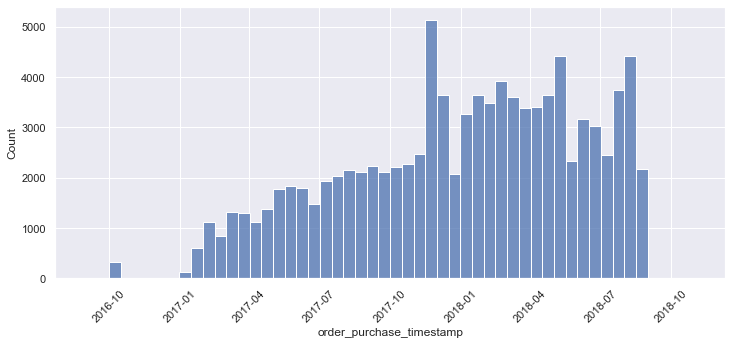

In [70]:
plt.subplots(figsize=(12,5))
sns.histplot(orders_df, x = 'order_purchase_timestamp', bins = 52, 
             binrange=(dates.date2num(datetime.datetime(2016,9,1)),dates.date2num(datetime.datetime(2018,10,31))))
plt.xticks(rotation = 45)
plt.show()

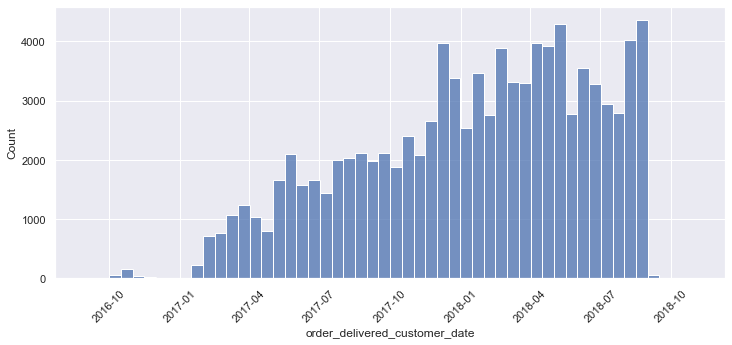

In [71]:
plt.subplots(figsize=(12,5))
sns.histplot(orders_df, x = 'order_delivered_customer_date', bins = 52, 
             binrange=(dates.date2num(datetime.datetime(2016,9,1)),dates.date2num(datetime.datetime(2018,10,31))))
plt.xticks(rotation = 45)
plt.show()

### 3.2.2 Temps de Livraison (en Jours)

In [72]:
orders_df['delivery_time'] = (orders_df['order_delivered_customer_date'] - \
                              orders_df['order_purchase_timestamp']).dt.total_seconds().div(24*60*60)

In [73]:
orders_df['delivery_time'].describe()

count    96476.000000
mean        12.558702
std          9.546530
min          0.533414
25%          6.766403
50%         10.217755
75%         15.720327
max        209.628611
Name: delivery_time, dtype: float64

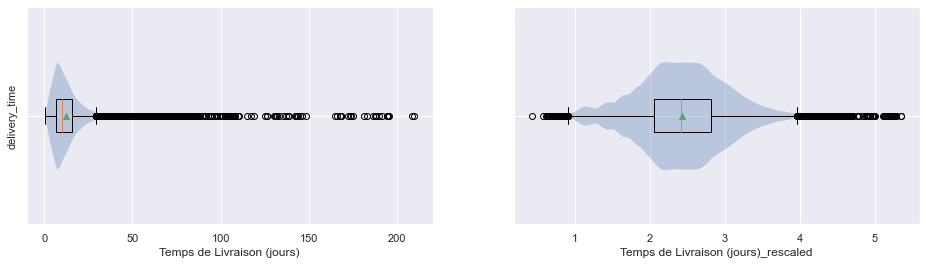

In [74]:
plot_box_violin(orders_df[['delivery_time']], 'Temps de Livraison (jours)', np.log1p)

In [75]:
orders_df['delivery_speed'] = orders_df['delivery_time'].apply(lambda x: 10/(10+x)).fillna(0)

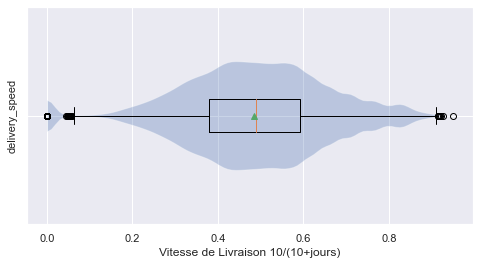

In [76]:
plot_box_violin(orders_df[['delivery_speed']],'Vitesse de Livraison 10/(10+jours)', None, figsize=(8,4))

### 3.2.3 Délai de la Livraison (en Jours)

In [77]:
orders_df['delivery_delay'] = (orders_df['order_delivered_customer_date'] - \
                               orders_df['order_estimated_delivery_date']).dt.total_seconds().div(24*60*60)
orders_df['delivery_delay'].describe()

count    96476.000000
mean       -11.179120
std         10.186113
min       -146.016123
25%        -16.244384
50%        -11.948941
75%         -6.390000
max        188.975081
Name: delivery_delay, dtype: float64

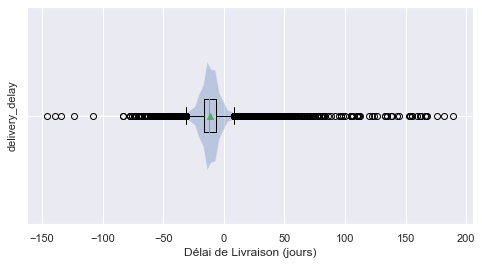

In [78]:
plot_box_violin(orders_df[['delivery_delay']], 'Délai de Livraison (jours)', None, figsize=(8,4))

### 3.2.4 Heure de la Journée du Achat

L'heure de la journée à laquelle un client effecte des achats est peut-être une feature intéressante pour la segmentation des clients. On va définir le début de la journée à 5h du matin ce que correspond plus au rythme naturel humain.

(array([   0.,    0.,    0.,    0.,    0.,  188.,  502., 1231., 2967.,
        4785., 6177., 6578., 5995., 6518., 6569., 6454., 6675., 6150.,
        5769., 5982., 6193., 6217., 5816., 4123., 2394., 1170.,  510.,
         272.,  206.]),
 array([ 0,  1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12, 13, 14, 15, 16,
        17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29]),
 <BarContainer object of 29 artists>)

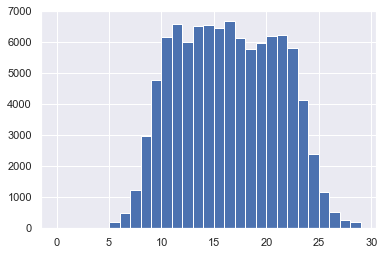

In [79]:
plt.hist((orders_df['order_purchase_timestamp'].dt.hour.astype(float) + 19).mod(24) + 5, bins = range(30))
#plt.hist(orders_df['order_purchase_timestamp'].dt.hour.astype(int), bins = range(30))

In [80]:
orders_df['order_purchase_timeofday'] = (orders_df['order_purchase_timestamp'].dt.hour.astype(float) + \
                                         orders_df['order_purchase_timestamp'].dt.minute.astype(float).div(60) + 19).mod(24) + 5
orders_df['order_purchase_timeofday'].describe()

count    99441.000000
mean        16.361577
std          4.780706
min          5.000000
25%         12.383333
50%         16.250000
75%         20.333333
max         28.983333
Name: order_purchase_timeofday, dtype: float64

### 3.2.5 Statut de la Commande

In [81]:
orders_df['order_status'].value_counts()

delivered      96478
shipped         1107
canceled         625
unavailable      609
invoiced         314
processing       301
created            5
approved           2
Name: order_status, dtype: int64

In [82]:
orders_df[orders_df['order_delivered_customer_date'].isna()]['order_status'].value_counts()

shipped        1107
canceled        619
unavailable     609
invoiced        314
processing      301
delivered         8
created           5
approved          2
Name: order_status, dtype: int64

On va imputer la date de livraison pour les commandes qui étaient apparemmanet livrées avec celui de l'estimation de livraison

In [83]:
select = (orders_df['order_status'] == 'delivered')
orders_df.loc[select, 'order_delivered_customer_date'] = orders_df.loc[select, 'order_delivered_customer_date'].fillna(
                                                             orders_df.loc[select, 'order_estimated_delivery_date'])

In [84]:
orders_df[~orders_df['order_delivered_customer_date'].isna()]['order_status'].value_counts()

delivered    96478
canceled         6
Name: order_status, dtype: int64

In [85]:
orders_df[orders_df['order_delivered_carrier_date'].isna()]['order_status'].value_counts()

unavailable    609
canceled       550
invoiced       314
processing     301
created          5
approved         2
delivered        2
Name: order_status, dtype: int64

In [86]:
orders_df[~orders_df['order_delivered_carrier_date'].isna()]['order_status'].value_counts()

delivered    96476
shipped       1107
canceled        75
Name: order_status, dtype: int64

In [87]:
orders_df[orders_df['order_approved_at'].isna()]['order_status'].value_counts()

canceled     141
delivered     14
created        5
Name: order_status, dtype: int64

On va réduire le nombre de catégories du statut à trois:
* aborted (= 'canceled' ou 'unavailable')
* delivered (= 'delivered')
* in_progress (= tout le reste)

In [88]:
orders_df['order_status_simplified'] = np.where(orders_df['order_status'].isin(['canceled', 'unavailable']), 'aborted', 
                                       np.where(orders_df['order_status'] == 'delivered', 'delivered', 'in_progress'))
orders_df['order_status_simplified'].value_counts(normalize=True)

delivered      0.970203
in_progress    0.017387
aborted        0.012409
Name: order_status_simplified, dtype: float64

In [89]:
orders_df['order_is_delivered'] = orders_df['order_status_simplified'].map({'delivered': 1, 'in_progress': 0, 'aborted': -1})
orders_df['order_is_delivered'].describe()

count    99441.000000
mean         0.957794
std          0.255429
min         -1.000000
25%          1.000000
50%          1.000000
75%          1.000000
max          1.000000
Name: order_is_delivered, dtype: float64

### 3.2.6 Localisation du Client

Il y a plusieurs coordonnées-gps pour une code postale. On va prendre la moyenne comme localisation. 

In [90]:
gps_coordinates_df = datasets['geolocation'].groupby(by='geolocation_zip_code_prefix')[
                             ['geolocation_lat', 'geolocation_lng']].mean()
gps_coordinates_df

,geolocation_lat,geolocation_lng
geolocation_zip_code_prefix,,
01001,-23.550190,-46.634024
01002,-23.548146,-46.634979
01003,-23.548994,-46.635731
01004,-23.549799,-46.634757
01005,-23.549456,-46.636733
...,...,...
99960,-27.953722,-52.025511
99965,-28.183372,-52.039850
99970,-28.343766,-51.874689


In [91]:
len(set(orders_df['customer_zip_code_prefix'].unique()) - set(datasets['geolocation']['geolocation_zip_code_prefix'].unique()))

157

Pas tous les codes postales ont des coordonnées-gps. On va approximer avec celles qui suivent en order numérique. Les codes postales sont liées géographiquement, alors c'est une approximation assez proche.

In [92]:
#If the zip code is not contained in the geolocation table, we will use the gps-coordinates of the previous zip code.
#Since zip codes are geographically linked this should be a decent approximation.
gps_coordinates_df = pd.DataFrame([str(i).zfill(5) for i in range(1001,100000)], 
                                  columns=['geolocation_zip_code_prefix']).merge(
                                  gps_coordinates_df.reset_index(), 
                                  on='geolocation_zip_code_prefix', 
                                  how='left').fillna(method='ffill').set_index('geolocation_zip_code_prefix')

In [93]:
orders_df[['customer_lat', 'customer_lng']] = gps_coordinates_df.loc[orders_df['customer_zip_code_prefix'], 
                                                                     ['geolocation_lat','geolocation_lng']].set_index(
                                                                     orders_df.index)
orders_df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 99441 entries, 0 to 99440
Data columns (total 20 columns):
 #   Column                         Non-Null Count  Dtype         
---  ------                         --------------  -----         
 0   order_id                       99441 non-null  object        
 1   customer_id                    99441 non-null  object        
 2   order_status                   99441 non-null  object        
 3   order_purchase_timestamp       99441 non-null  datetime64[ns]
 4   order_approved_at              99281 non-null  datetime64[ns]
 5   order_delivered_carrier_date   97658 non-null  datetime64[ns]
 6   order_delivered_customer_date  96484 non-null  datetime64[ns]
 7   order_estimated_delivery_date  99441 non-null  datetime64[ns]
 8   customer_unique_id             99441 non-null  object        
 9   customer_zip_code_prefix       99441 non-null  object        
 10  customer_city                  99441 non-null  object        
 11  customer_state 

### 3.2.7 Densité de Clients

Pour estimer la dénsité des régions, on va compter les nombre des clients dans cette région, i.e. le nombre de clients avec le même code postal, et pour prendre des régions un peu plus large le nombre des clients avec les même trois prèmiers chiffres pour leur code postal.

In [94]:
client_zip_code_density_df = pd.DataFrame([str(i).zfill(5) for i in range(1001,100000)], 
                                  columns=['customer_zip_code_prefix'])
client_zip_code_density_df = client_zip_code_density_df.merge(pd.DataFrame(1000*orders_df.sort_values(
                                'order_purchase_timestamp').groupby('customer_unique_id').last()[
                                'customer_zip_code_prefix'].value_counts(normalize=True)).reset_index().rename(
                                columns={'index':'customer_zip_code_prefix', 
                                         'customer_zip_code_prefix':'customer_zip_code_density'}), 
                                on='customer_zip_code_prefix',how='left')

In [95]:
client_zip_code_density_df['customer_zip_code_density'].fillna(0, inplace=True)
client_zip_code_density_df = client_zip_code_density_df.set_index('customer_zip_code_prefix')

In [96]:
orders_df['customer_zip_code_density'] = orders_df['customer_zip_code_prefix'].fillna(0).apply(
                                            lambda x: client_zip_code_density_df.loc[x])

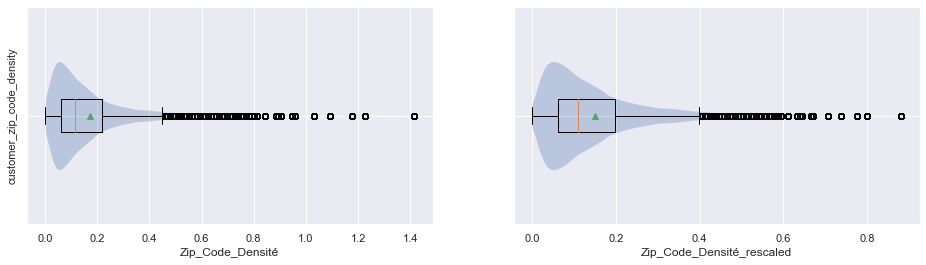

In [97]:
plot_box_violin(orders_df[['customer_zip_code_density']], 'Zip_Code_Densité', np.log1p)

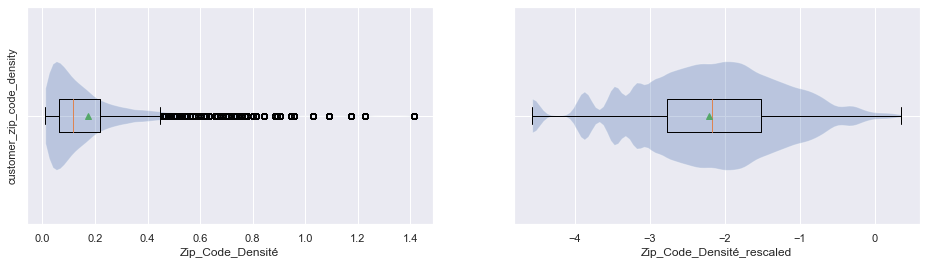

In [98]:
select = orders_df['customer_zip_code_density'] != 0
plot_box_violin(orders_df[select][['customer_zip_code_density']], 'Zip_Code_Densité', np.log)

In [99]:
orders_df['customer_zip_code_prefix_3digits'] = orders_df['customer_zip_code_prefix'].str[0:3]

In [100]:
client_zip_code_density_df = 500*orders_df['customer_zip_code_prefix_3digits'].value_counts(normalize=True)

In [101]:
orders_df['customer_zip_code_density_3digits'] = orders_df['customer_zip_code_prefix_3digits'].apply(
                                            lambda x: client_zip_code_density_df.loc[x])

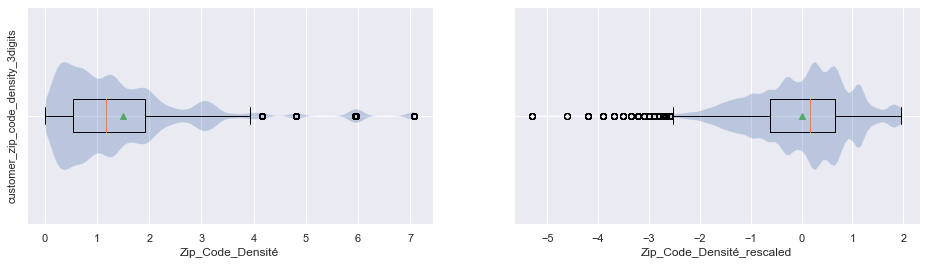

In [102]:
plot_box_violin(orders_df[['customer_zip_code_density_3digits']], 'Zip_Code_Densité', np.log)

## 3.3 Les Détails des Commandes (Prix, Articles, Vendeurs, Taille, Poids)

Une commande peut contenier plusieurs articles. On va créer un dataset qui contient les details d'un commande, plus spécifiquement tous les articles vendues
* identificateur = order_id + order_item_id

In [103]:
orderdetails_df = datasets["order_items"].merge(datasets["products"], on='product_id', how='left')
orderdetails_df = orderdetails_df.merge(datasets["sellers"], on='seller_id', how='left')

In [104]:
orderdetails_df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 112650 entries, 0 to 112649
Data columns (total 18 columns):
 #   Column                      Non-Null Count   Dtype         
---  ------                      --------------   -----         
 0   order_id                    112650 non-null  object        
 1   order_item_id               112650 non-null  int64         
 2   product_id                  112650 non-null  object        
 3   seller_id                   112650 non-null  object        
 4   shipping_limit_date         112650 non-null  datetime64[ns]
 5   price                       112650 non-null  float64       
 6   freight_value               112650 non-null  float64       
 7   product_category_name       111047 non-null  object        
 8   product_name_lenght         111047 non-null  float64       
 9   product_description_lenght  111047 non-null  float64       
 10  product_photos_qty          111047 non-null  float64       
 11  product_weight_g            112632 non-

### 3.3.1 Nombre d'Articles par Commande

On va déterminer le nombre d'articles par commande. 

In [105]:
orders_df = orders_df.merge(orderdetails_df.groupby(by='order_id')['order_item_id'].count().rename("order_item_quantity"), 
                            on='order_id', how='left')

In [106]:
orders_df['order_item_quantity'].value_counts().sort_index()

1.0     88863
2.0      7516
3.0      1322
4.0       505
5.0       204
6.0       198
7.0        22
8.0         8
9.0         3
10.0        8
11.0        4
12.0        5
13.0        1
14.0        2
15.0        2
20.0        2
21.0        1
Name: order_item_quantity, dtype: int64

In [107]:
orders_df[orders_df['order_item_quantity'].isna()]['order_status'].value_counts()

unavailable    603
canceled       164
created          5
invoiced         2
shipped          1
Name: order_status, dtype: int64

In [108]:
orders_df['order_item_quantity'] = orders_df['order_item_quantity'].fillna(1)

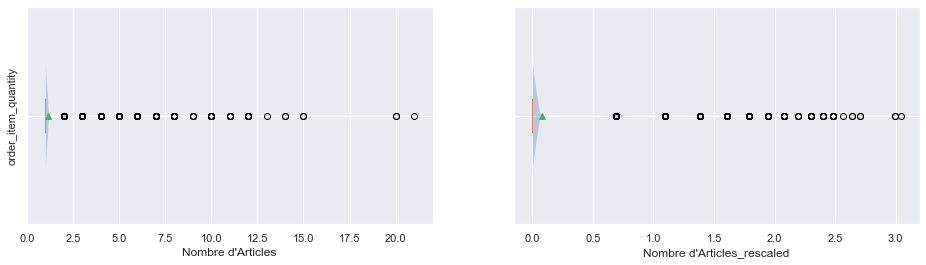

In [109]:
plot_box_violin(orders_df[['order_item_quantity']], "Nombre d'Articles", np.log)

In [110]:
orders_df['has_multiple_items'] = orders_df['order_item_quantity'] > 1

### 3.3.2 Le Prix Total du Commande (Articles et Livraison)

In [111]:
orders_df = orders_df.merge(orderdetails_df.groupby(by='order_id')['price'].sum().rename("order_price"), 
                            on='order_id', how='left')

In [112]:
orders_df = orders_df.merge(orderdetails_df.groupby(by='order_id')['freight_value'].sum().rename("order_freight"), 
                            on='order_id', how='left')

In [113]:
orders_df['order_total_price'] = orders_df['order_price']+orders_df['order_freight']

In [114]:
orders_df[['order_price', 'order_freight', 'order_total_price']].describe()

,order_price,order_freight,order_total_price
count,98666.000000,98666.000000,98666.000000
mean,137.754076,22.823562,160.577638
std,210.645145,21.650909,220.466087
min,0.850000,0.000000,9.590000
25%,45.900000,13.850000,61.980000
50%,86.900000,17.170000,105.290000
75%,149.900000,24.040000,176.870000
max,13440.000000,1794.960000,13664.080000


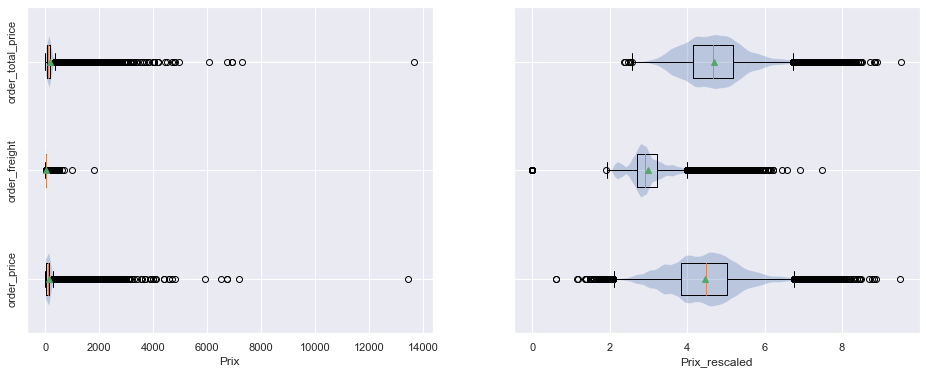

In [115]:
plot_box_violin(orders_df[['order_price', 'order_freight', 'order_total_price']], "Prix", np.log1p, figsize=(16,6))

In [116]:
orders_df[orders_df['order_price'].isna()]['order_status'].value_counts()

unavailable    603
canceled       164
created          5
invoiced         2
shipped          1
Name: order_status, dtype: int64

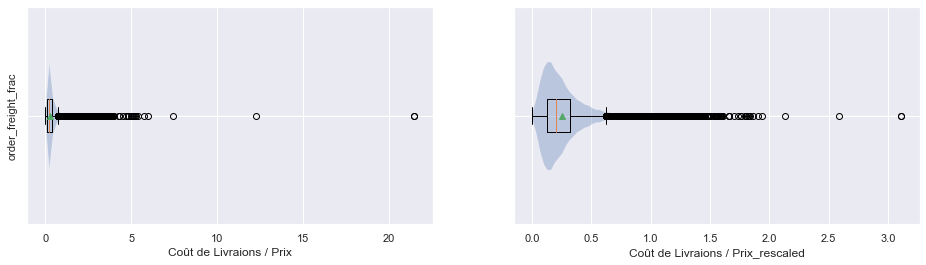

In [117]:
orders_df['order_freight_frac'] = orders_df['order_freight'].div(orders_df['order_price'])
plot_box_violin(orders_df[['order_freight_frac']], "Coût de Livraions / Prix", np.log1p)

In [118]:
orders_df['order_freight_frac'].describe()

count    98666.000000
mean         0.308389
std          0.314762
min          0.000000
25%          0.131864
50%          0.224374
75%          0.380191
max         21.447059
Name: order_freight_frac, dtype: float64

### 3.3.3 Localisation des Vendeurs

In [119]:
orderdetails_df[['seller_lat', 'seller_lng']] = gps_coordinates_df.loc[orderdetails_df['seller_zip_code_prefix'], 
                                                                       ['geolocation_lat','geolocation_lng']].set_index(
                                                                       orderdetails_df.index)

In [120]:
orderdetails_df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 112650 entries, 0 to 112649
Data columns (total 20 columns):
 #   Column                      Non-Null Count   Dtype         
---  ------                      --------------   -----         
 0   order_id                    112650 non-null  object        
 1   order_item_id               112650 non-null  int64         
 2   product_id                  112650 non-null  object        
 3   seller_id                   112650 non-null  object        
 4   shipping_limit_date         112650 non-null  datetime64[ns]
 5   price                       112650 non-null  float64       
 6   freight_value               112650 non-null  float64       
 7   product_category_name       111047 non-null  object        
 8   product_name_lenght         111047 non-null  float64       
 9   product_description_lenght  111047 non-null  float64       
 10  product_photos_qty          111047 non-null  float64       
 11  product_weight_g            112632 non-

In [121]:
orderdetails_df = orderdetails_df.merge(orders_df[['order_id', 'customer_lat', 'customer_lng']], on='order_id', how='left')

In [122]:
var = ['customer_lat', 'customer_lng', 'seller_lat', 'seller_lng']
orderdetails_df['shipping_distance'] = [get_distance(a,b) for a,b in zip(orderdetails_df[var[0:2]].values,
                                                                         orderdetails_df[var[2:]].values)]

In [123]:
orderdetails_df['shipping_distance']=orderdetails_df['shipping_distance'].round()

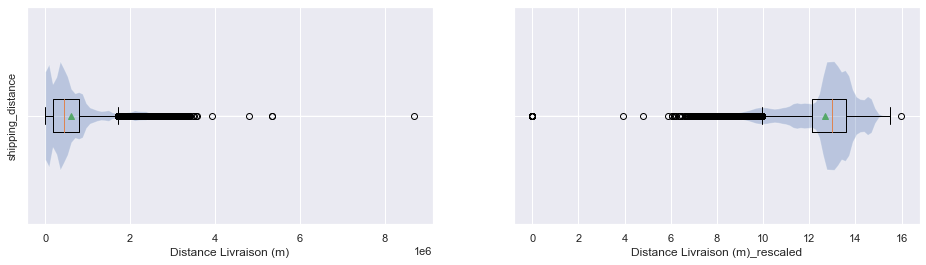

In [124]:
plot_box_violin(orderdetails_df[['shipping_distance']], "Distance Livraison (m)", np.log1p)

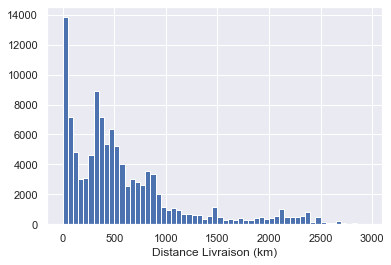

In [125]:
plt.hist(orderdetails_df['shipping_distance'].div(1000), bins=range(0,3000,50))
plt.xlabel('Distance Livraison (km)')
plt.show()

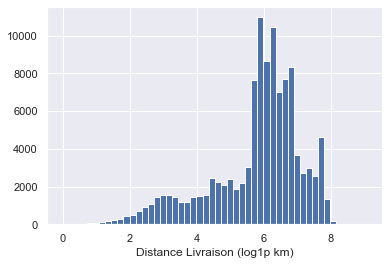

In [126]:
plt.hist(orderdetails_df['shipping_distance'].div(1000).apply(np.log1p), bins=50)
plt.xlabel('Distance Livraison (log1p km)')
plt.show()

In [127]:
orders_df = orders_df.merge(orderdetails_df.groupby(by='order_id')[
                            'shipping_distance'].mean().rename('order_avg_shipping_distance'),
                            on='order_id', how='left')

In [128]:
orders_df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 99441 entries, 0 to 99440
Data columns (total 30 columns):
 #   Column                             Non-Null Count  Dtype         
---  ------                             --------------  -----         
 0   order_id                           99441 non-null  object        
 1   customer_id                        99441 non-null  object        
 2   order_status                       99441 non-null  object        
 3   order_purchase_timestamp           99441 non-null  datetime64[ns]
 4   order_approved_at                  99281 non-null  datetime64[ns]
 5   order_delivered_carrier_date       97658 non-null  datetime64[ns]
 6   order_delivered_customer_date      96484 non-null  datetime64[ns]
 7   order_estimated_delivery_date      99441 non-null  datetime64[ns]
 8   customer_unique_id                 99441 non-null  object        
 9   customer_zip_code_prefix           99441 non-null  object        
 10  customer_city                     

### 3.3.4 Catégories des Produits

On va juste rapidement regarder les catégories des produits. 

In [129]:
orderdetails_df['product_category_name'].describe()

count              111047
unique                 73
top       cama_mesa_banho
freq                11115
Name: product_category_name, dtype: object

In [130]:
set(orderdetails_df['product_category_name'].unique()) - set(datasets['category_translation']['product_category_name'].unique())

{nan, 'pc_gamer', 'portateis_cozinha_e_preparadores_de_alimentos'}

In [131]:
datasets['category_translation']['product_category_name_english'].unique()

array(['health_beauty', 'computers_accessories', 'auto', 'bed_bath_table',
       'furniture_decor', 'sports_leisure', 'perfumery', 'housewares',
       'telephony', 'watches_gifts', 'food_drink', 'baby', 'stationery',
       'tablets_printing_image', 'toys', 'fixed_telephony',
       'garden_tools', 'fashion_bags_accessories', 'small_appliances',
       'consoles_games', 'audio', 'fashion_shoes', 'cool_stuff',
       'luggage_accessories', 'air_conditioning',
       'construction_tools_construction',
       'kitchen_dining_laundry_garden_furniture',
       'costruction_tools_garden', 'fashion_male_clothing', 'pet_shop',
       'office_furniture', 'market_place', 'electronics',
       'home_appliances', 'party_supplies', 'home_confort',
       'costruction_tools_tools', 'agro_industry_and_commerce',
       'furniture_mattress_and_upholstery', 'books_technical',
       'home_construction', 'musical_instruments',
       'furniture_living_room', 'construction_tools_lights',
       'indust

**Traduction** pour la catégorie qui n'est pas dans le dataset de traduction:
* **portateis_cozinha_e_preparadores_de_alimentos** = kitchen utensils and food preparers = 'housewares' or 'la_cuisine'
* **pc_gamer** = pc_gamer

Si on veut utiliser les catégories, il va falloir les regrouper, car 73 catégories sont trop des catégories. En bas, en broullion: 

* **fashion** - 'fashion_bags_accessories', 'fashion_shoes', 'fashion_male_clothing', 'fashion_underwear_beach', 'fashion_sport', 'fashion_childrens_clothes', 'fashio_female_clothing'
* **books** - 'stationery', 'books_technical', 'art', 'books_general_interest', 'books_imported', 'arts_and_craftmanship', 'cine_photo'
* **furniture** - 'furniture_bedroom', 'furniture_living_room', 'furniture_mattress_and_upholstery', 'office_furniture', 'kitchen_dining_laundry_garden_furniture', 'furniture_decor', 'bed_bath_table'
* **construction_tools** - 'garden_tools', 'construction_tools_construction', 'costruction_tools_garden', 'costruction_tools_tools',
* 'home_construction', 'construction_tools_lights', 'construction_tools_safety'
* **security** - 'security_and_services', 'signaling_and_security'
* **commerce** - 'industry_commerce_and_business', 'agro_industry_and_commerce'
* **food_drink** - 'drinks', 'food', 'food_drink'
* **health_beauty** - 'health_beauty', 'diapers_and_hygiene', 'perfumery'
* **flowers** - 'flowers'
* **electronics** - 'dvds_blu_ray', 'cds_dvds_musicals', 'electronics', 'audio', 'consoles_games'
* **telephone** - 'telephony', 'fixed_telephony'
* **computers** - 'computers', 'tablets_printing_image', 'computers_accessories'
* **home** - 'small_appliances_home_oven_and_coffee', 'la_cuisine', 'home_appliances_2', 'home_appliances', 'small_appliances', 'housewares', 'home_confort', 'home_comfort_2'
* **pet_shop** - 'pet_shop'
* **auto** - 'auto'
* **baby_children** - 'baby', 'toys'
* **music** - musical_instruments, music
* **sports_leisure** - sports_leisure
* **accessories** - luggage_accessories, watches_gifts
* **stuff** - cool_stuff, market_place
* **air_conditioning**
* **party_holidays** - party_supplies, christmas_supplies

### 3.3.5 Le Poids et la Taille des Produits

In [132]:
orders_df = orders_df.merge(orderdetails_df.groupby(by='order_id')['product_weight_g'].sum().rename("order_total_weight"), 
                            on='order_id', how='left')
orders_df['order_total_weight'].describe()

count     98666.000000
mean       2390.027669
std        4773.239825
min           0.000000
25%         300.000000
50%         750.000000
75%        2066.750000
max      184400.000000
Name: order_total_weight, dtype: float64

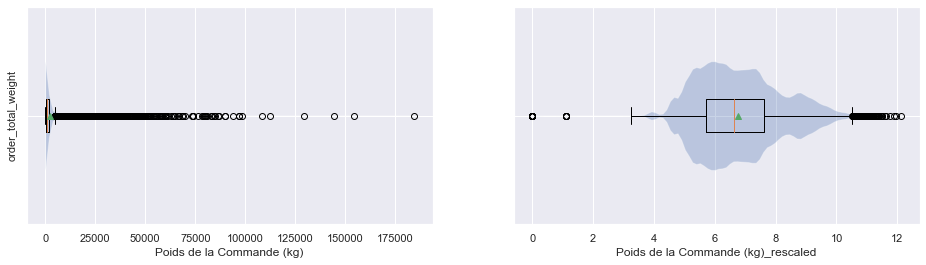

In [133]:
plot_box_violin(orders_df[['order_total_weight']], "Poids de la Commande (kg)", np.log1p)

In [134]:
orderdetails_df['product_volume'] = orderdetails_df[['product_length_cm', 
                                                     'product_height_cm', 
                                                     'product_width_cm']].apply(lambda x: x[0]*x[1]*x[2], axis=1)
orderdetails_df['product_volume'].describe()

count    112632.000000
mean      15243.709567
std       23418.524686
min         168.000000
25%        2851.500000
50%        6480.000000
75%       18375.000000
max      296208.000000
Name: product_volume, dtype: float64

In [135]:
orders_df = orders_df.merge(orderdetails_df.groupby(by='order_id')['product_volume'].sum().rename("order_total_volume"), 
                            on='order_id', how='left')

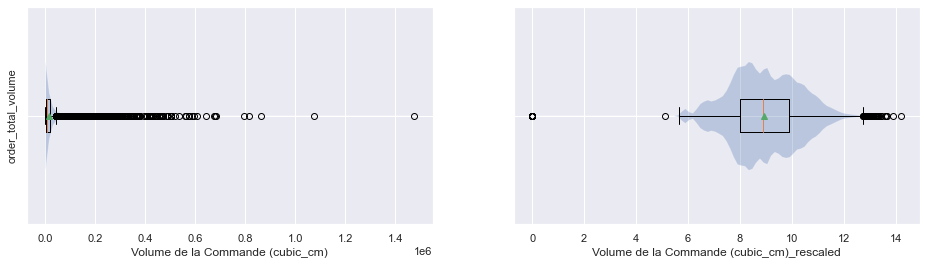

In [136]:
plot_box_violin(orders_df[['order_total_volume']], "Volume de la Commande (cubic_cm)", np.log1p)

In [137]:
orders_df[orders_df['order_total_volume'].isna()]['order_status'].value_counts()

unavailable    603
canceled       164
created          5
invoiced         2
shipped          1
Name: order_status, dtype: int64

## 3.4 Les Détails des Payments 

Une commande peut être payer en plusieurs versements.
* identificateur = order_id + payment_sequential

In [138]:
payments_df = datasets['order_payments']
payments_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 103886 entries, 0 to 103885
Data columns (total 5 columns):
 #   Column                Non-Null Count   Dtype  
---  ------                --------------   -----  
 0   order_id              103886 non-null  object 
 1   payment_sequential    103886 non-null  int64  
 2   payment_type          103886 non-null  object 
 3   payment_installments  103886 non-null  int64  
 4   payment_value         103886 non-null  float64
dtypes: float64(1), int64(2), object(2)
memory usage: 4.0+ MB


In [139]:
set(payments_df['order_id'].unique())-set(orders_df['order_id'].unique())

set()

In [140]:
set(orders_df['order_id'].unique())-set(payments_df['order_id'].unique())

{'bfbd0f9bdef84302105ad712db648a6c'}

### 3.4.1 Nombre de Paiements

In [141]:
orders_df = orders_df.merge(payments_df.groupby(by='order_id')['payment_sequential'].count().rename("order_payments_quantity"), 
                            on='order_id', how='left')
orders_df['order_payments_quantity'].value_counts().sort_index()

1.0     96479
2.0      2382
3.0       301
4.0       108
5.0        52
6.0        36
7.0        28
8.0        11
9.0         9
10.0        5
11.0        8
12.0        8
13.0        3
14.0        2
15.0        2
19.0        2
21.0        1
22.0        1
26.0        1
29.0        1
Name: order_payments_quantity, dtype: int64

In [142]:
orders_df = orders_df.merge(payments_df.groupby(by='order_id')[
                            'payment_installments'].sum().rename("order_installments_total"), on='order_id', how='left')
orders_df['order_installments_total'].value_counts().sort_index()

0.0         2
1.0     46264
2.0     13605
3.0     10709
4.0      7223
5.0      5295
6.0      3967
7.0      1689
8.0      4239
9.0       693
10.0     5224
11.0      129
12.0      146
13.0       29
14.0       23
15.0       80
16.0       26
17.0        9
18.0       28
19.0        3
20.0       29
21.0        5
22.0        2
23.0        1
24.0       16
25.0        2
26.0        1
29.0        1
Name: order_installments_total, dtype: int64

In [143]:
orders_df[orders_df['order_payments_quantity'].isna()]['order_status'].value_counts()

delivered    1
Name: order_status, dtype: int64

In [144]:
orders_df[orders_df['order_installments_total'].isna() | (orders_df['order_installments_total'] == 0)][
          'order_status'].value_counts()

delivered    3
Name: order_status, dtype: int64

In [145]:
orders_df['order_payments_quantity'] = orders_df['order_payments_quantity'].fillna(1)
select = orders_df['order_installments_total'].isna() | (orders_df['order_installments_total'] == 0)
orders_df.loc[select, 'order_installments_total'] = 1
orders_df['order_installments_total'].value_counts().sort_index()

1.0     46267
2.0     13605
3.0     10709
4.0      7223
5.0      5295
6.0      3967
7.0      1689
8.0      4239
9.0       693
10.0     5224
11.0      129
12.0      146
13.0       29
14.0       23
15.0       80
16.0       26
17.0        9
18.0       28
19.0        3
20.0       29
21.0        5
22.0        2
23.0        1
24.0       16
25.0        2
26.0        1
29.0        1
Name: order_installments_total, dtype: int64

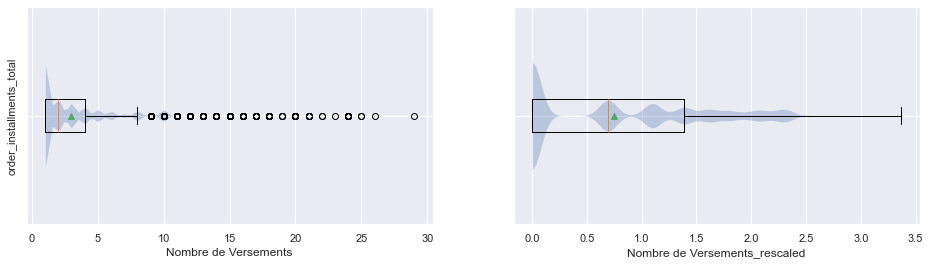

In [146]:
plot_box_violin(orders_df[['order_installments_total']], "Nombre de Versements", np.log)

### 3.4.2 Type de Paiement

In [147]:
payments_df['payment_type'].value_counts()

credit_card    76795
boleto         19784
voucher         5775
debit_card      1529
not_defined        3
Name: payment_type, dtype: int64

In [148]:
payments_df.groupby(by='order_id')['payment_type'].apply(set).apply(', '.join).value_counts()

credit_card                74259
boleto                     19784
credit_card, voucher        2245
voucher                     1621
debit_card                  1527
not_defined                    3
credit_card, debit_card        1
Name: payment_type, dtype: int64

In [149]:
orders_df = orders_df.merge(payments_df.groupby(by='order_id')['payment_type'].apply(
                            lambda x: 'voucher' in list(x)).rename('used_voucher'),
                            on='order_id', how='left')
orders_df['used_voucher'] = orders_df['used_voucher'].fillna(False).astype(bool)
orders_df['used_voucher'].describe()

count     99441
unique        2
top       False
freq      95575
Name: used_voucher, dtype: object

In [150]:
orders_df[orders_df['used_voucher'] == False]['order_payments_quantity'].value_counts()

1.0    95286
2.0      289
Name: order_payments_quantity, dtype: int64

In [151]:
orders_df[orders_df['used_voucher'] == False]['order_installments_total'].value_counts().sort_index()

1.0     45073
2.0     12148
3.0     10273
4.0      6996
5.0      5151
6.0      3863
7.0      1610
8.0      4205
9.0       648
10.0     5210
11.0       39
12.0      135
13.0       20
14.0       20
15.0       75
16.0       23
17.0        8
18.0       28
20.0       29
21.0        3
22.0        1
23.0        1
24.0       16
Name: order_installments_total, dtype: int64

In [152]:
orders_df = orders_df.merge(payments_df.groupby(by='order_id')['payment_type'].apply(
                            lambda x: 'boleto' in list(x)).rename('used_boleto'),
                            on='order_id', how='left')
orders_df['used_boleto'] = orders_df['used_boleto'].fillna(False).astype(bool)
orders_df['used_boleto'].describe()

count     99441
unique        2
top       False
freq      79657
Name: used_boleto, dtype: object

In [153]:
orders_df = orders_df.merge(payments_df.groupby(by='order_id')['payment_type'].apply(
                            lambda x: any(i in list(x) for i in ('debit_card', 'credit_card'))).rename('used_card'),
                            on='order_id', how='left')
orders_df['used_card'] = orders_df['used_card'].fillna(False).astype(bool)
orders_df['used_card'].describe()

count     99441
unique        2
top        True
freq      78032
Name: used_card, dtype: object

### 3.4.3 Paiement total

In [154]:
orders_df = orders_df.merge(payments_df.groupby(by='order_id')['payment_value'].sum().rename('order_payment_total'),
                            on='order_id', how='left')
orders_df['order_payment_total'].describe()

count    99440.000000
mean       160.990267
std        221.951257
min          0.000000
25%         62.010000
50%        105.290000
75%        176.970000
max      13664.080000
Name: order_payment_total, dtype: float64

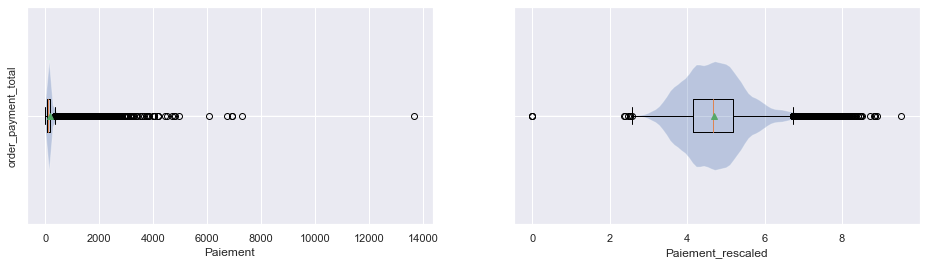

In [155]:
plot_box_violin(orders_df[['order_payment_total']], 'Paiement', np.log1p)

In [156]:
#petit vérification que le prix et le payment sont cohérent
select = orders_df['order_status'] == 'delivered'
(orders_df[select]['order_total_price']-orders_df[select]['order_payment_total']).describe()

count    96477.000000
mean        -0.029349
std          1.138706
min       -182.810000
25%          0.000000
50%          0.000000
75%          0.000000
max         51.620000
dtype: float64

In [157]:
select= abs(orders_df['order_total_price']-orders_df['order_payment_total']) > 0.05
orders_df[select].describe(include='all')

<ipython-input-157-117fc4edf079>:2: FutureWarning: Treating datetime data as categorical rather than numeric in `.describe` is deprecated and will be removed in a future version of pandas. Specify `datetime_is_numeric=True` to silence this warning and adopt the future behavior now.
  orders_df[select].describe(include='all')


,order_id,customer_id,order_status,order_purchase_timestamp,order_approved_at,order_delivered_carrier_date,order_delivered_customer_date,order_estimated_delivery_date,customer_unique_id,customer_zip_code_prefix,...,order_freight_frac,order_avg_shipping_distance,order_total_weight,order_total_volume,order_payments_quantity,order_installments_total,used_voucher,used_boleto,used_card,order_payment_total
count,260,260,260,260,260,258,256,260,260,260,...,260.000000,2.600000e+02,260.000000,260.000000,260.000000,260.000000,260,260,260,260.000000
unique,260,260,3,260,259,258,256,173,260,254,...,NaN,NaN,NaN,NaN,NaN,NaN,2,1,1,NaN
top,84d6d9710c8af32b5e88f2d1c14ab871,1099d033c74a027a78c1d26e1de9c8ad,delivered,2018-01-27 22:09:48,2018-08-20 15:55:42,2018-02-02 14:44:52,2018-02-06 19:35:01,2018-02-14 00:00:00,95cc7f48ae7cfa0afebd560092cdc92e,07600,...,NaN,NaN,NaN,NaN,NaN,NaN,False,False,True,NaN
freq,1,1,256,1,2,1,1,5,1,3,...,NaN,NaN,NaN,NaN,NaN,NaN,253,260,260,NaN
first,NaN,NaN,NaN,2016-10-06 14:59:56,2016-10-06 19:31:39,2016-10-10 19:31:39,2016-10-13 19:31:39,2016-11-30 00:00:00,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
last,NaN,NaN,NaN,2018-08-26 22:41:03,2018-08-26 22:50:21,2018-08-27 17:58:00,2018-08-31 00:14:30,2018-09-14 00:00:00,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
mean,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,0.399758,6.490968e+05,1701.273077,12792.650000,1.065385,6.257692,NaN,NaN,NaN,120.618000
std,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,0.399950,6.144239e+05,3444.511326,18708.367628,0.247680,3.574758,NaN,NaN,NaN,134.133692
min,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,0.041406,4.188000e+03,0.000000,0.000000,1.000000,1.000000,NaN,NaN,NaN,16.380000
25%,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,0.179680,2.623014e+05,250.000000,2417.000000,1.000000,4.000000,NaN,NaN,NaN,52.930000


## 3.5 Les Evaluations des Commandes

Ce n'est pas toute à fait claire comment les évaluations sont liées aux commandes. Dans la documentation, c'est dit que c'est fait via le 'order_id'. Cependent il y a des 'order_id' qui on plusieurs évaluations. De même, il y a des 'review_id' qui on plusieurs évaluations avec différentes 'order_id'.

* identificateur index = order_id + review_id 

Pour les évaluations, on va utiliser ou créer les features suivantes (quand il y a un doublon, on a prendre la moyenne):
* la note d'évaluation
* le nombre de jours entre la création de la demande d'évaluation et la response
* s'il y a une évaluation ou pas 
* s'il y a un titre pour l'évaluation ou pas
* s'il y a un commentaire ou pas

In [158]:
reviews_df = datasets['order_reviews']

In [159]:
reviews_df['review_response_time'] = (reviews_df['review_answer_timestamp'] - \
                                      reviews_df['review_creation_date']).dt.total_seconds().div(24*60*60)
reviews_df['review_response_time'].describe()

count    99224.000000
mean         3.148993
std          9.890049
min          0.089225
25%          1.004870
50%          1.674948
75%          3.103565
max        518.699213
Name: review_response_time, dtype: float64

In [160]:
reviews_df['has_review_title'] = (~reviews_df['review_comment_title'].isna())
reviews_df['has_review_message'] = (~reviews_df['review_comment_message'].isna())

In [161]:
reviews_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 99224 entries, 0 to 99223
Data columns (total 10 columns):
 #   Column                   Non-Null Count  Dtype         
---  ------                   --------------  -----         
 0   review_id                99224 non-null  object        
 1   order_id                 99224 non-null  object        
 2   review_score             99224 non-null  int64         
 3   review_comment_title     11568 non-null  object        
 4   review_comment_message   40977 non-null  object        
 5   review_creation_date     99224 non-null  datetime64[ns]
 6   review_answer_timestamp  99224 non-null  datetime64[ns]
 7   review_response_time     99224 non-null  float64       
 8   has_review_title         99224 non-null  bool          
 9   has_review_message       99224 non-null  bool          
dtypes: bool(2), datetime64[ns](2), float64(1), int64(1), object(4)
memory usage: 6.2+ MB


In [162]:
orders_df = orders_df.merge(reviews_df.groupby(by='order_id')[['review_score', 
                                                               'review_response_time', 
                                                               'has_review_title', 
                                                               'has_review_message']
                                                              ].apply(np.mean),
                            on='order_id', how='left')

In [163]:
orders_df[['review_score', 'review_response_time', 'has_review_title', 'has_review_message']].describe()

,review_score,review_response_time,has_review_title,has_review_message
count,98673.000000,98673.000000,98673.000000,98673.000000
mean,4.086793,3.149493,0.117063,0.413321
std,1.346274,9.898147,0.321482,0.492162
min,1.000000,0.089225,0.000000,0.000000
25%,4.000000,1.005127,0.000000,0.000000
50%,5.000000,1.677743,0.000000,0.000000
75%,5.000000,3.101678,0.000000,1.000000
max,5.000000,518.699213,1.000000,1.000000


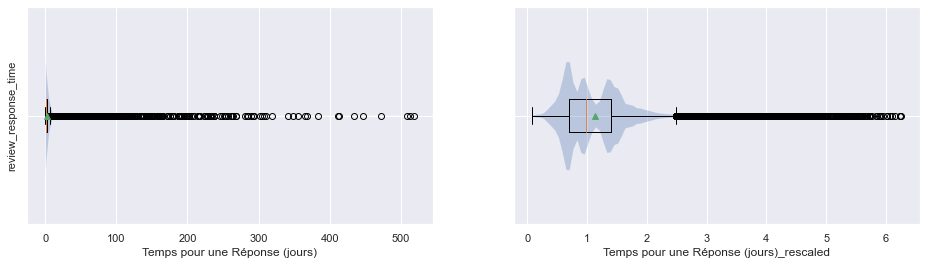

In [164]:
plot_box_violin(orders_df[['review_response_time']], "Temps pour une Réponse (jours)", np.log1p)

In [165]:
orders_df['has_review'] = orders_df['review_score'].notna()
orders_df['review_score'] = orders_df['review_score'].fillna(3)
orders_df['has_review_title'] = orders_df['has_review_title'].fillna(False).astype(bool)
orders_df['has_review_message'] = orders_df['has_review_message'].fillna(False).astype(bool)

In [166]:
orders_df['review_response_speed'] = orders_df['review_response_time'].apply(lambda x: 1/(1+x)).fillna(0)

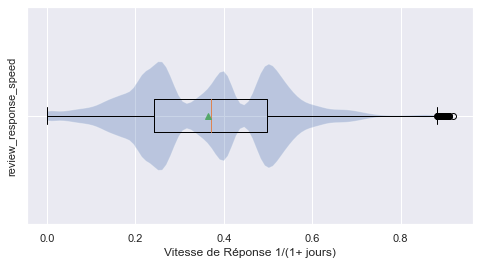

In [167]:
plot_box_violin(orders_df[['review_response_speed']], "Vitesse de Réponse 1/(1+ jours)", None, figsize=(8,4))

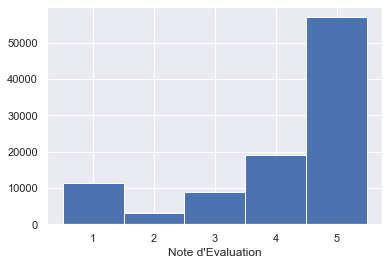

In [168]:
plt.hist(orders_df['review_score'], bins=[i+0.5 for i in range(6)])
plt.xlabel("Note d'Evaluation")
plt.show()

In [169]:
orders_df = orders_df.merge(reviews_df.groupby(by='order_id')['review_answer_timestamp'].mean(),
                            on='order_id', how='left')

(array([   0.,    0.,    0.,    0.,    0.,  586.,  426.,  484., 1061.,
        2663., 4953., 6904., 6358., 5344., 4877., 4298., 4190., 4221.,
        4343., 5048., 5041., 5843., 5758., 6936., 6431., 5696., 3752.,
        2311., 1149.]),
 array([ 0,  1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12, 13, 14, 15, 16,
        17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29]),
 <BarContainer object of 29 artists>)

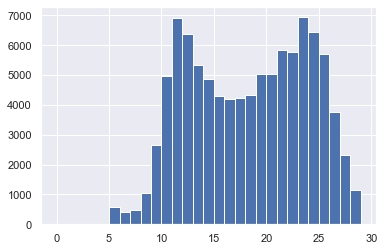

In [170]:
plt.hist((orders_df['review_answer_timestamp'].dt.hour.astype(float) + 19).mod(24) + 5, bins = range(30))

(array([   0.,    0.,    0.,    0.,    0.,  188.,  502., 1231., 2967.,
        4785., 6177., 6578., 5995., 6518., 6569., 6454., 6675., 6150.,
        5769., 5982., 6193., 6217., 5816., 4123., 2394., 1170.,  510.,
         272.,  206.]),
 array([ 0,  1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12, 13, 14, 15, 16,
        17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29]),
 <BarContainer object of 29 artists>)

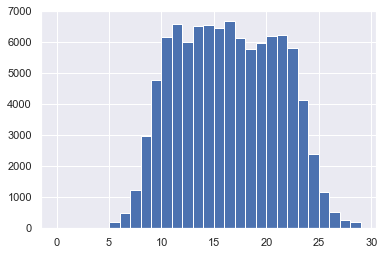

In [171]:
plt.hist((orders_df['order_purchase_timestamp'].dt.hour.astype(float) + 19).mod(24) + 5, bins = range(30))

## 3.6 Les Commandes -revisitées

On va soit imputer soit écarter les valeurs nulles (dans des colonnes importantes) du dataset des commandes. De plus, on va regrouper des classifications qui ne sont pas très populées.

In [172]:
orders_df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 99441 entries, 0 to 99440
Data columns (total 45 columns):
 #   Column                             Non-Null Count  Dtype         
---  ------                             --------------  -----         
 0   order_id                           99441 non-null  object        
 1   customer_id                        99441 non-null  object        
 2   order_status                       99441 non-null  object        
 3   order_purchase_timestamp           99441 non-null  datetime64[ns]
 4   order_approved_at                  99281 non-null  datetime64[ns]
 5   order_delivered_carrier_date       97658 non-null  datetime64[ns]
 6   order_delivered_customer_date      96484 non-null  datetime64[ns]
 7   order_estimated_delivery_date      99441 non-null  datetime64[ns]
 8   customer_unique_id                 99441 non-null  object        
 9   customer_zip_code_prefix           99441 non-null  object        
 10  customer_city                     

In [173]:
#orders_df = orders_df.drop(columns=['order_approved_at','order_delivered_carrier_date'])

### 3.6.1 Le Temps et le Délai de Livraison 

In [174]:
orders_df[~orders_df['order_delivered_customer_date'].isna()][['order_is_delivered',
                                                               'order_status_simplified',
                                                               'order_status']].value_counts(sort=False)

order_is_delivered  order_status_simplified  order_status
-1                  aborted                  canceled            6
 1                  delivered                delivered       96478
dtype: int64

In [175]:
orders_df[orders_df['order_delivered_customer_date'].isna()][['order_is_delivered',
                                                              'order_status_simplified',
                                                              'order_status']].value_counts(sort=False)

order_is_delivered  order_status_simplified  order_status
-1                  aborted                  canceled         619
                                             unavailable      609
 0                  in_progress              approved           2
                                             created            5
                                             invoiced         314
                                             processing       301
                                             shipped         1107
dtype: int64

In [176]:
orders_df[['delivery_time', 'delivery_delay']].describe()

,delivery_time,delivery_delay
count,96476.000000,96476.000000
mean,12.558702,-11.179120
std,9.546530,10.186113
min,0.533414,-146.016123
25%,6.766403,-16.244384
50%,10.217755,-11.948941
75%,15.720327,-6.390000
max,209.628611,188.975081


In [177]:
#impute the delivery time and the delivery day with 365 days for the orders 
#that are not delivered and will not be delivered
select = orders_df['order_is_delivered'] == -1
orders_df.loc[select, ['delivery_time', 'delivery_delay']] = orders_df.loc[select, 
                                                                           ['delivery_time', 'delivery_delay']].fillna(2*365)

In [178]:
#assume that the delivery will be made on either the estimated delivery date 
#or a day after the last day in the dataset 
#- which ever one is the most recent
max_date = max(orders_df['order_delivered_customer_date'].max(), orders_df['order_purchase_timestamp'].max()) + \
           datetime.timedelta(days=1)

In [179]:
orders_df['delivery_time'] = orders_df['delivery_time'].fillna(orders_df[['order_purchase_timestamp',
                                                                          'order_estimated_delivery_date']].apply(
                                lambda x: max(x[1],max_date)-x[0], axis=1).dt.total_seconds().div(24*60*60))
orders_df['delivery_delay'] = orders_df['delivery_delay'].fillna(orders_df['order_estimated_delivery_date'].apply(
                                  lambda x: max(x,max_date)-x).dt.total_seconds().div(24*60*60))
orders_df[['delivery_time', 'delivery_delay']].describe()

,delivery_time,delivery_delay
count,99441.000000,99441.000000
mean,27.150017,3.665381
std,92.729820,94.767716
min,0.533414,-146.016123
25%,6.873796,-16.157662
50%,10.486019,-11.329676
75%,16.378171,-6.167697
max,773.843738,730.000000


In [180]:
orders_df[select]['delivery_delay'].fillna(orders_df[select]['order_estimated_delivery_date'].apply(
    lambda x: max(x,max_date) - x).dt.total_seconds().div(24*60*60)).value_counts()

 730.000000    1228
 12.919340        1
-44.390984        1
-45.370012        1
-41.216863        1
-16.542662        1
-28.379282        1
Name: delivery_delay, dtype: int64

In [181]:
orders_df[select & (orders_df['delivery_delay'] < (2*365))]

,order_id,customer_id,order_status,order_purchase_timestamp,order_approved_at,order_delivered_carrier_date,order_delivered_customer_date,order_estimated_delivery_date,customer_unique_id,customer_zip_code_prefix,...,used_boleto,used_card,order_payment_total,review_score,review_response_time,has_review_title,has_review_message,has_review,review_response_speed,review_answer_timestamp
2921,1950d777989f6a877539f53795b4c3c3,1bccb206de9f0f25adc6871a1bcf77b2,canceled,2018-02-19 19:48:52,2018-02-19 20:56:05,2018-02-20 19:57:13,2018-03-21 22:03:51,2018-03-09,6a04c8339c44b23e189446216a494569,32071,...,False,True,44.09,3.0,0.166887,False,True,True,0.856981,2018-03-11 04:00:19
8791,dabf2b0e35b423f94618bf965fcb7514,5cdec0bb8cbdf53ffc8fdc212cd247c6,canceled,2016-10-09 00:56:52,2016-10-09 13:36:58,2016-10-13 13:36:59,2016-10-16 14:36:59,2016-11-30,2f96790fba243100730c8d1185dd2f25,05846,...,False,True,140.22,5.0,0.863345,False,True,True,0.536669,2016-10-19 20:43:13
58266,770d331c84e5b214bd9dc70a10b829d0,6c57e6119369185e575b36712766b0ef,canceled,2016-10-07 14:52:30,2016-10-07 15:07:10,2016-10-11 15:07:11,2016-10-14 15:07:11,2016-11-29,59a7bb642795ddc85534fbd5f7360334,20091,...,False,True,263.93,1.0,18.839236,False,True,True,0.050405,2016-12-19 20:08:30
59332,8beb59392e21af5eb9547ae1a9938d06,bf609b5741f71697f65ce3852c5d2623,canceled,2016-10-08 20:17:50,2016-10-09 14:34:30,2016-10-14 22:45:26,2016-10-19 18:47:43,2016-11-30,f9af3bfab584769f34c314b222d34263,20091,...,False,True,111.22,1.0,4.720937,False,True,True,0.174797,2016-10-24 17:18:09
92636,65d1e226dfaeb8cdc42f665422522d14,70fc57eeae292675927697fe03ad3ff5,canceled,2016-10-03 21:01:41,2016-10-04 10:18:57,2016-10-25 12:14:28,2016-11-08 10:58:34,2016-11-25,b8b8726af116a5cfb35b0315ecef9172,22770,...,False,True,35.61,1.0,0.878264,False,True,True,0.532407,2016-11-09 21:04:42
94399,2c45c33d2f9cb8ff8b1c86cc28c11c30,de4caa97afa80c8eeac2ff4c8da5b72e,canceled,2016-10-09 15:39:56,2016-10-10 10:40:49,2016-10-14 10:40:50,2016-11-09 14:53:50,2016-12-08,d93a22bb52bb2f41a7267b8a02370781,88058,...,False,True,153.51,1.0,6.864109,False,True,True,0.127160,2016-11-16 20:44:19


### 3.6.2 Distance de Livraison, Poids et Taille de la Livraison

In [182]:
orders_df[orders_df['order_avg_shipping_distance'].isna()][['order_is_delivered',
                                                            'order_status_simplified',
                                                            'order_status']].value_counts(sort=False)

order_is_delivered  order_status_simplified  order_status
-1                  aborted                  canceled        164
                                             unavailable     603
 0                  in_progress              created           5
                                             invoiced          2
                                             shipped           1
dtype: int64

In [183]:
#We will throw out the orders that are being processed but don't have a location for the vendor, i.e. a shipping distance
#And will do the same for the weight and the volume of the package. 
#For the orders that were aborted we will assume that the seller is located where most of the sellers are located

In [184]:
select = orders_df['order_avg_shipping_distance'].isna() & (orders_df['order_is_delivered'] != -1)
orders_df = orders_df[~select]

In [185]:
top_seller_zip_code = orderdetails_df['seller_zip_code_prefix'].value_counts().index.values[0]
top_seller_gps_point = gps_coordinates_df.loc[top_seller_zip_code,['geolocation_lat','geolocation_lng']].values

In [186]:
select = orders_df['order_avg_shipping_distance'].isna()
orders_df.loc[select, 'order_avg_shipping_distance'] = [get_distance(x, top_seller_gps_point) for x in orders_df[select][
                                                        ['customer_lat', 'customer_lng']].values]

In [187]:
orders_df[['order_total_weight', 'order_total_volume']] = orders_df[['order_total_weight', 'order_total_volume']].fillna(0)

In [188]:
orders_df[['order_avg_shipping_distance', 'order_total_weight', 'order_total_volume']].describe()

,order_avg_shipping_distance,order_total_weight,order_total_volume
count,9.943300e+04,99433.000000,9.943300e+04
mean,6.028432e+05,2371.591625,1.726720e+04
std,5.945458e+05,4759.389823,3.032293e+04
min,0.000000e+00,0.000000,0.000000e+00
25%,1.915510e+05,300.000000,2.880000e+03
50%,4.349260e+05,738.000000,7.168000e+03
75%,8.002310e+05,2050.000000,1.980000e+04
max,8.687633e+06,184400.000000,1.476000e+06


### 3.6.3 Le Prix de la Commande

In [189]:
orders_df['order_total_price'] = orders_df['order_total_price'].fillna(orders_df['order_payment_total'])
orders_df['order_price'] = orders_df['order_price'].fillna(orders_df['order_total_price'])
orders_df['order_freight'] = orders_df['order_freight'].fillna(0)
orders_df['order_freight_frac'] = orders_df['order_freight_frac'].fillna(0)

### 3.6.4 Le Temps de Résponse

In [190]:
orders_df[orders_df['review_response_time'].isna()][['order_is_delivered',
                                                     'order_status_simplified',
                                                     'order_status']].value_counts(sort=False)

order_is_delivered  order_status_simplified  order_status
-1                  aborted                  canceled         20
                                             unavailable      14
 0                  in_progress              invoiced          5
                                             processing        6
                                             shipped          75
 1                  delivered                delivered       646
dtype: int64

In [191]:
orders_df['review_response_time'].describe()

count    98667.000000
mean         3.149469
std          9.898416
min          0.089225
25%          1.005127
50%          1.677674
75%          3.101667
max        518.699213
Name: review_response_time, dtype: float64

In [192]:
#impute the review response time with 2*365 days for the orders that have been delivered or will not be delivered
#for the orders still in progress imput the value = 2 days, which is between the average and the mean.
select = orders_df['order_is_delivered'] != 0
orders_df.loc[select, 'review_response_time'] = orders_df.loc[select, 'review_response_time'].fillna(2*365)
orders_df.loc[~select, 'review_response_time'] = orders_df.loc[~select, 'review_response_time'].fillna(2)

## 3.7 Corrélations et PCA

### 3.7.1 Les Corrélations

In [193]:
orders_df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 99433 entries, 0 to 99440
Data columns (total 45 columns):
 #   Column                             Non-Null Count  Dtype         
---  ------                             --------------  -----         
 0   order_id                           99433 non-null  object        
 1   customer_id                        99433 non-null  object        
 2   order_status                       99433 non-null  object        
 3   order_purchase_timestamp           99433 non-null  datetime64[ns]
 4   order_approved_at                  99278 non-null  datetime64[ns]
 5   order_delivered_carrier_date       97657 non-null  datetime64[ns]
 6   order_delivered_customer_date      96484 non-null  datetime64[ns]
 7   order_estimated_delivery_date      99433 non-null  datetime64[ns]
 8   customer_unique_id                 99433 non-null  object        
 9   customer_zip_code_prefix           99433 non-null  object        
 10  customer_city                     

<AxesSubplot:>

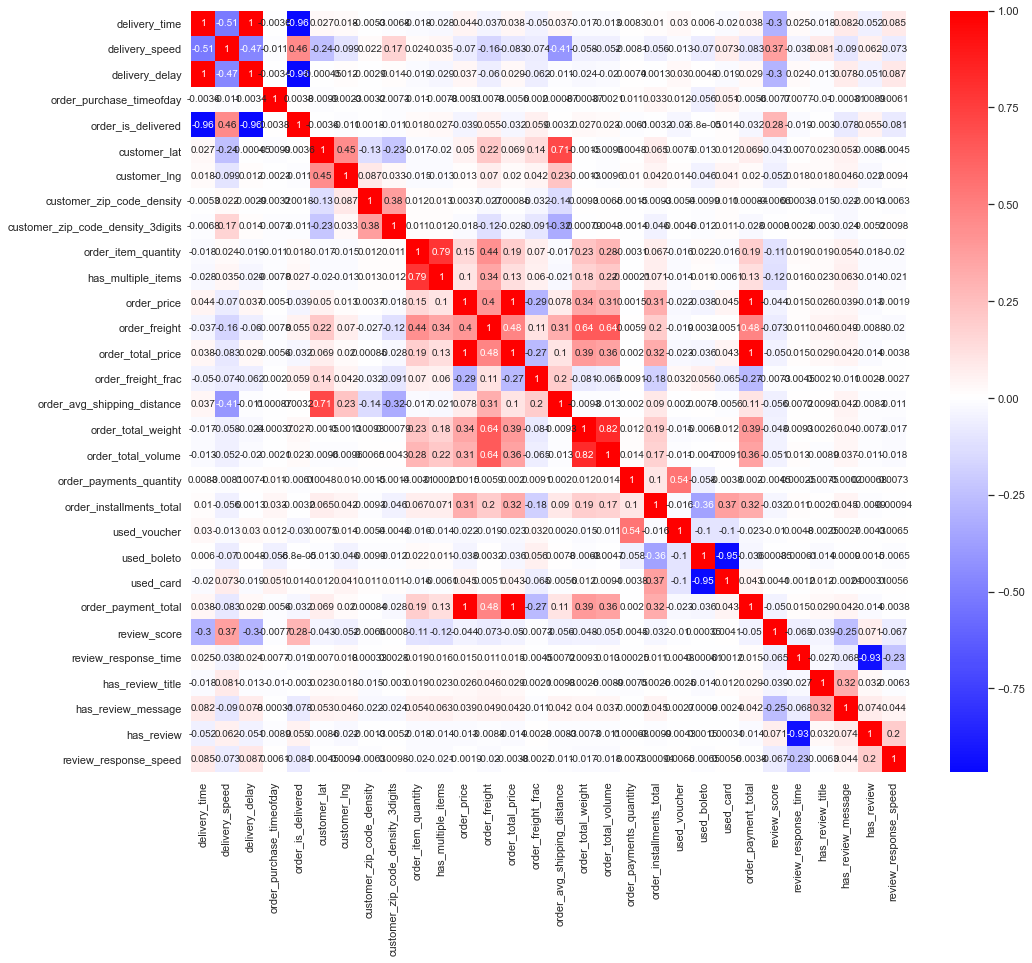

In [194]:
corr = orders_df.corr()
fig, ax = plt.subplots(figsize = (16,14))
sns.heatmap(corr, center = 0, cmap = 'bwr', annot = True, cbar = True)

### 3.7.2 Un PCA avec les Commandes

In [195]:
num_cols = [o for o in orders_df.columns if orders_df[o].dtype in (float, int, np.int64, bool) ]
X = orders_df[num_cols].dropna()
X.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 99432 entries, 0 to 99440
Data columns (total 30 columns):
 #   Column                             Non-Null Count  Dtype  
---  ------                             --------------  -----  
 0   delivery_time                      99432 non-null  float64
 1   delivery_speed                     99432 non-null  float64
 2   delivery_delay                     99432 non-null  float64
 3   order_purchase_timeofday           99432 non-null  float64
 4   order_is_delivered                 99432 non-null  int64  
 5   customer_lat                       99432 non-null  float64
 6   customer_lng                       99432 non-null  float64
 7   customer_zip_code_density          99432 non-null  float64
 8   customer_zip_code_density_3digits  99432 non-null  float64
 9   order_item_quantity                99432 non-null  float64
 10  has_multiple_items                 99432 non-null  bool   
 11  order_price                        99432 non-null  flo

In [196]:
#rescale X in preparation for PCA # Standardize the data
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X) #note that X_scaled is an array!
X_scaled = pd.DataFrame(X_scaled, index = X.index, columns = X.columns)

In [197]:
# Select the number of principal components we will return
num_components = len(X_scaled.columns)

# Create the PCA model
pca = PCA(n_components=num_components)

# Fit the model with the standardised data
pca.fit(X_scaled)

PCA(n_components=30)

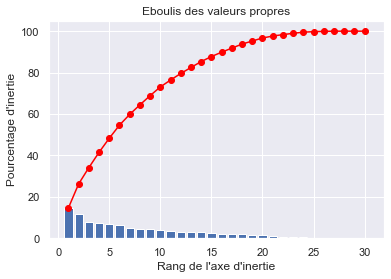

In [198]:
display_scree_plot(pca, name='PCA')

In [199]:
pcs = pca.components_ 
print(X_scaled.columns.values)
for i in pcs:
    print(i) 

['delivery_time' 'delivery_speed' 'delivery_delay'
 'order_purchase_timeofday' 'order_is_delivered' 'customer_lat'
 'customer_lng' 'customer_zip_code_density'
 'customer_zip_code_density_3digits' 'order_item_quantity'
 'has_multiple_items' 'order_price' 'order_freight' 'order_total_price'
 'order_freight_frac' 'order_avg_shipping_distance' 'order_total_weight'
 'order_total_volume' 'order_payments_quantity' 'order_installments_total'
 'used_voucher' 'used_boleto' 'used_card' 'order_payment_total'
 'review_score' 'review_response_time' 'has_review_title'
 'has_review_message' 'has_review' 'review_response_speed']
[ 7.16588398e-02 -1.11713282e-01  6.30754941e-02 -3.36188078e-04
 -6.34446428e-02  8.30763491e-02  3.74859388e-02 -1.10446407e-02
 -4.09368370e-02  1.96078238e-01  1.64055399e-01  3.97333760e-01
  3.55222722e-01  4.14768963e-01 -9.79332222e-02  1.03425396e-01
  3.14640334e-01  3.06923219e-01  9.16692913e-03  2.01708045e-01
 -1.16704887e-02 -4.70989608e-02  5.11837234e-02  4.147

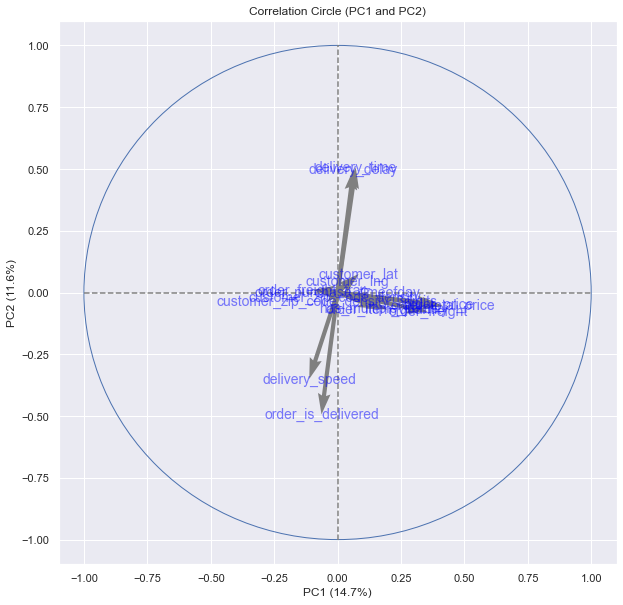

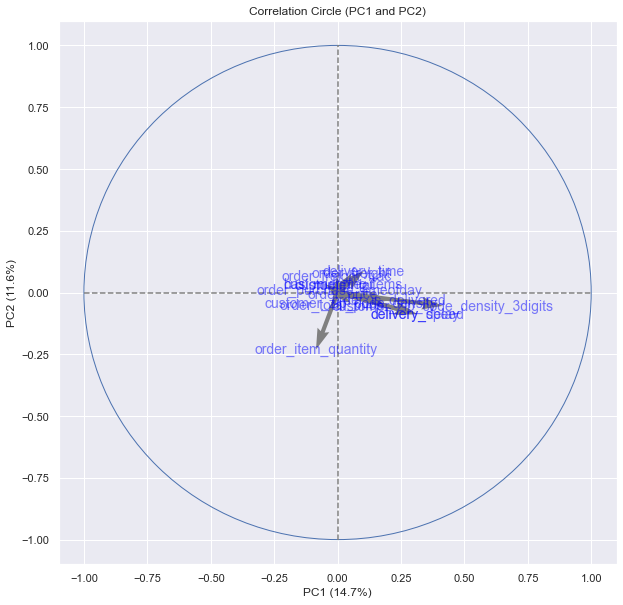

In [200]:
# Generate a correlation circle
display_circles(pcs[:,:15], num_components, pca, [(0,1)], labels = np.array(X_scaled.columns),)
display_circles(pcs[:,15:], num_components, pca, [(0,1)], labels = np.array(X_scaled.columns),) 

# 4. Les Clients

## 4.1 L'analyse RFM

### 4.1.1 Introduction

L'analyse 'RFM' (recency, frequency, monetary) est une méthode standarde pour ségmenter les clients en groupes cibles. Alors, on va créer les correspondantes features.

**recency** - le temps depuis la dernière achât

**frequency** - la fréquence avec laquelle le client fait des achâts / nombre d'achâts (per une période de temps)

**monetary** - argent dépensé (pendent une période de temps)

### 4.1.2 Recency

In [201]:
customers_df = customers_df.merge(orders_df.groupby(by='customer_unique_id')[
                                  'order_purchase_timestamp'].max().rename('last_purchase_date'), 
                                  on='customer_unique_id')

In [202]:
customers_df['recency'] = (customers_df['last_purchase_date'] - \
                           customers_df['last_purchase_date'].max()).dt.total_seconds().div(24*60*60)

In [203]:
customers_df['recency'].describe()

count    96089.000000
mean      -288.186307
std        153.400693
min       -772.843738
25%       -397.348866
50%       -268.898484
75%       -163.872998
max          0.000000
Name: recency, dtype: float64

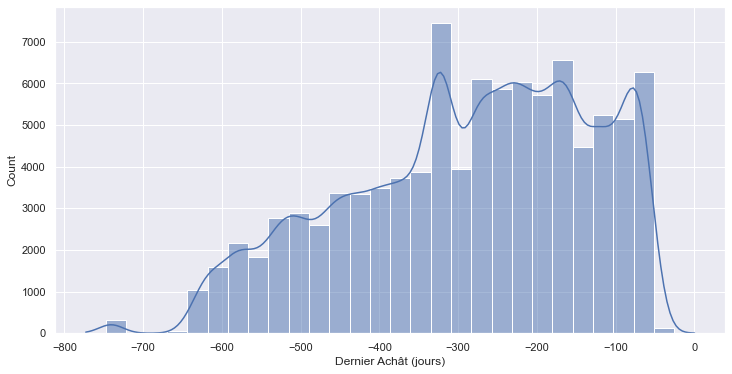

In [204]:
fig, ax = plt.subplots(figsize = (12,6))
sns.histplot(customers_df['recency'], kde=True, ax=ax, bins=30)
plt.xlabel("Dernier Achât (jours)")
plt.show()

### 4.1.3 Frequency

In [205]:
customers_df = customers_df.merge(orders_df.groupby(by='customer_unique_id')['order_id'].unique(
                                  ).apply(len).rename('number_of_purchases'), 
                                  on='customer_unique_id')

In [206]:
customers_df['number_of_purchases'].value_counts(bins=[0,1,2,10,100], normalize=True)

(-0.001, 1.0]    0.968821
(1.0, 2.0]       0.028557
(2.0, 10.0]      0.002612
(10.0, 100.0]    0.000010
Name: number_of_purchases, dtype: float64

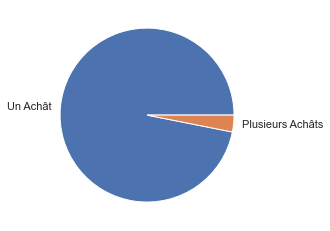

In [207]:
plt.pie(pd.cut(customers_df['number_of_purchases'], bins=[0,1,100]).value_counts(),
       labels=["Un Achât", "Plusieurs Achâts"])
plt.show()

In [208]:
customers_df['repeat_customer'] = (customers_df['number_of_purchases'] > 1)

### 4.1.4 Monetary

In [209]:
customers_df = customers_df.merge(orders_df.groupby(by='customer_unique_id')['order_payment_total'].sum(
                                   ).rename('monetary'), on='customer_unique_id')

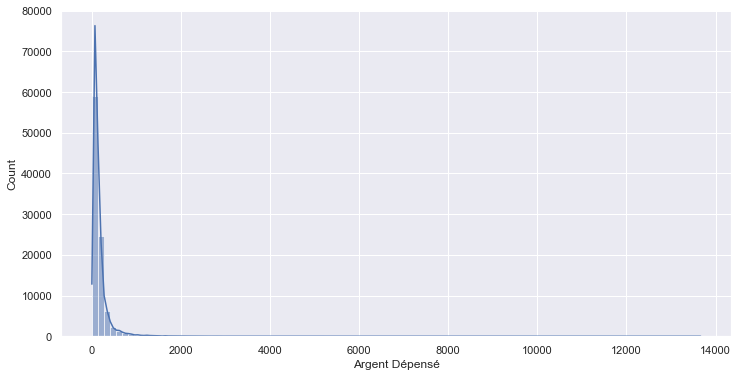

In [210]:
fig, ax = plt.subplots(figsize = (12,6))
sns.histplot(customers_df['monetary'], kde=True, ax=ax, bins=100)
plt.xlabel("Argent Dépensé")
plt.show()

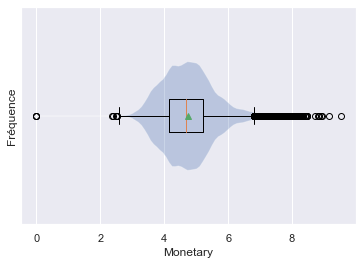

In [211]:
plt.boxplot(customers_df['monetary'].apply(np.log1p).dropna(), showmeans = True, showfliers = True, vert=False)
plt.violinplot(customers_df['monetary'].apply(np.log1p).dropna(), showextrema = False, vert=False)
plt.yticks(ticks=[])
ax = plt.gca()
ax.set_ylabel('Fréquence')
ax.set_xlabel('Monetary')
plt.show()

## 4.2 Activité Internet

In [212]:
customers_df = customers_df.merge(orders_df.groupby(by='customer_unique_id')[
                ['order_purchase_timestamp', 'review_answer_timestamp']].apply(
                get_avg_timestamp).rename('online_timeofday'), on='customer_unique_id', how='left')

In [213]:
customers_df = customers_df.merge(orders_df.groupby(by='customer_unique_id')[['order_purchase_timestamp']].apply(
                get_avg_timestamp).rename('purchase_timeofday'), on='customer_unique_id', how='left')

In [214]:
customers_df = customers_df.merge(orders_df.groupby(by='customer_unique_id')[['review_answer_timestamp']].apply(
                   get_avg_timestamp).rename('review_timeofday'), on='customer_unique_id', how='left')

In [215]:
customers_df['review_timeofday'] = customers_df['review_timeofday'].fillna(customers_df['purchase_timeofday'])

In [216]:
for c in ['online_timeofday', 'purchase_timeofday', 'review_timeofday'] :
    customers_df[c] = pd.to_datetime(customers_df[c].astype(str)).dt.hour.astype(float) + \
                                   pd.to_datetime(customers_df[c].astype(str)).dt.minute.astype(float).div(60)
    customers_df[c] = (customers_df[c] + 19).mod(24) + 5

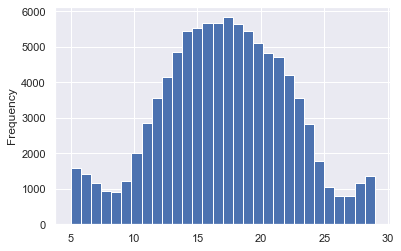

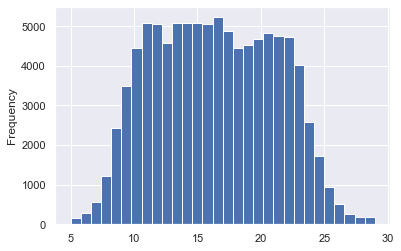

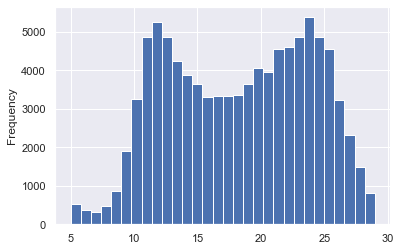

In [217]:
for c in ['online_timeofday', 'purchase_timeofday', 'review_timeofday'] :
    customers_df[c].plot.hist(bins=30)
    plt.show()

## 4.3 La Moyenne des Commandes

In [218]:
num_cols = [o for o in orders_df.columns if orders_df[o].dtype in (float, int, np.int64, bool) ]
customers_df = customers_df.merge(orders_df.groupby(by='customer_unique_id')[num_cols].mean(),
                                  on='customer_unique_id', how='left')

# 5. Export Des Donnés

In [219]:
customers_df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 96089 entries, 0 to 96088
Data columns (total 39 columns):
 #   Column                             Non-Null Count  Dtype         
---  ------                             --------------  -----         
 0   customer_unique_id                 96089 non-null  object        
 1   last_purchase_date                 96089 non-null  datetime64[ns]
 2   recency                            96089 non-null  float64       
 3   number_of_purchases                96089 non-null  int64         
 4   repeat_customer                    96089 non-null  bool          
 5   monetary                           96089 non-null  float64       
 6   online_timeofday                   96089 non-null  float64       
 7   purchase_timeofday                 96089 non-null  float64       
 8   review_timeofday                   96089 non-null  float64       
 9   delivery_time                      96089 non-null  float64       
 10  delivery_speed                    

In [220]:
filename = 'Olist_Cleaned_Orders'
orders_df.to_csv(os.getcwd() + '\\DataCleaned\\' + filename + '.csv')
filename = 'Olist_Cleaned_Customers'
customers_df.to_csv(os.getcwd() + '\\DataCleaned\\' + filename + '.csv')